# Exploratory Data Analysis of Voting History of the Uniswap Governance Protocol

**[Johnnatan Messias](https://johnnatan-messias.github.io/), March 2025**

We analyzed the voting history of the Uniswap Governance Protocol by gathering data from the Ethereum blockchain. This data, collected through an Archive Node, includes all voting history and transfers related to Uniswap from August 20th, 2021 (starting at block number 13,059,157) to August 19th, 2024 (up to block number 20,563,000).

**Uniswap dataset**: **Token: UNI**

| Event Name           | # of Events | Description                                                                                                                                                                                                                                                                                                                                                                                                                    |
| -------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Approval             | 798,107     | Standard ERC-20 approval event.                                                                                                                                                                                                                                                                                                                                                                                                |
| DelegateChanged      | 53,977      | Emitted when an account changes its delegate. This means that the delegatee will receive voting power from the sender. Users can only delegate to one address at a time, and the number of votes added to the delegatee’s vote count is equal to the user’s token balance. The delegation of votes will take effect from the current block until the sender either delegates to a different address or transfers their tokens. |
| DelegateVotesChanged | 163,347     | Emitted when a delegate account's vote balance changes.                                                                                                                                                                                                                                                                                                                                                                        |
| Transfer             | 4,765,566   | Emitted when users/holders transfer their tokens to another address.                                                                                                                                                                                                                                                                                                                                                           |

**Governor**

| Event Name       | # of Events | Description                                                                                  |
| ---------------- | ----------- | -------------------------------------------------------------------------------------------- |
| ProposalCanceled | 14          | Emitted when a proposal is canceled.                                                         |
| ProposalCreated  | 67          | Emitted when a new proposal is created.                                                      |
| ProposalExecuted | 43          | Emitted when a proposal is executed in the TimeLock.                                         |
| ProposalQueued   | 43          | Emitted when a proposal is added to the queue in the TimeLock.                               |
| VoteCast         | 51,580      | Emitted when a vote is cast on a proposal: 0 for against, 1 for in-favor, and 2 for abstain. |


In [1]:
import os
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

In [3]:
proposal_quorum = 0.04 * 1e9  # 4% of total supply
protocol_name = 'uniswap'
dynamic_chart = True
plot_style = 'png' if not dynamic_chart else None

In [4]:
from plot_utils import get_plotly_layout
from plot_utils import colors
import plotly.graph_objects as go
from plotly import express as px
from utils import load_dataframes
width, height = 850, 450

In [5]:
# Set directory paths
data_dir = os.path.abspath(
    os.path.join(os.getcwd(), "..", "data")) + os.sep
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots")) + os.sep

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [6]:
dfs = load_dataframes(path_dir=data_dir+protocol_name+os.sep)
for filename in dfs:
    print("Dataframe {} loaded".format(filename))

Loading dataframes: 100%|██████████| 12/12 [00:15<00:00,  1.28s/it]

Dataframe supporters_df loaded
Dataframe approval_df loaded
Dataframe proposal_cancelled_df loaded
Dataframe delegatechanged_df loaded
Dataframe proposals_queued_df loaded
Dataframe delegatevoteschanged_df loaded
Dataframe transfer_df loaded
Dataframe minterchanged_df loaded
Dataframe votes_weighted_df loaded
Dataframe proposal_created_df loaded
Dataframe votes_df loaded
Dataframe proposal_executed_df loaded


## Loading Labels


In [7]:
labels_dir = os.path.join(data_dir, "labels")
with open(os.path.join(labels_dir, "labels.json")) as f:
    labels = json.load(f)
print("Labels loaded: {}".format(len(labels)))

Labels loaded: 29738


## Loading Variables


In [8]:
supporters_df = dfs['supporters_df']
proposal_cancelled_df = dfs['proposal_cancelled_df']
# proposal_voting_period_df = dfs['proposal_voting_period_df']
proposals_queued_df = dfs['proposals_queued_df']
votes_weighted_df = dfs['votes_weighted_df']
proposal_created_df = dfs['proposal_created_df']
votes_df = dfs['votes_df']
proposal_executed_df = dfs['proposal_executed_df']
# proposal_voting_delay_df = dfs['proposal_voting_delay_df']

## Exploratory Data Analysis


### Basic Statistics


In [9]:
print("In this dataset, there are {} unique proposals created by {} unique proposers".format(
    proposal_created_df.proposalId.nunique(), proposal_created_df.proposer.nunique()))
print("\tThere are {} proposals executed".format(
    proposal_executed_df.proposalId.nunique()))
print("\tThere are {} proposals queued".format(
    proposals_queued_df.proposalId.nunique()))
print("\tThere are {} proposals canceled".format(
    proposal_cancelled_df.proposalId.nunique()))
# print("\tThere are {} Voting Period change".format(
#     proposal_voting_period_df.shape[0]))
# print("\tThere are {} unique Voting Delay Change".format(
#     proposal_voting_delay_df.shape[0]))

print("There are {} unique voters who have casted {} votes".format(
    votes_df.voter.nunique(), votes_df.shape[0]))

print("Votes were cast trough {} unique transactions".format(
    votes_df.transactionHash.nunique()))

# Empty voting power
print("There are {} votes with 0 voting power".format(
    votes_df.query('votes == 0').shape[0]))

In this dataset, there are 67 unique proposals created by 31 unique proposers
	There are 43 proposals executed
	There are 43 proposals queued
	There are 14 proposals canceled
There are 20695 unique voters who have casted 51580 votes
Votes were cast trough 51559 unique transactions
There are 4168 votes with 0 voting power


In [10]:
# Proposal creation distribution
data = pd.concat([proposal_created_df['proposer'].value_counts(), proposal_created_df['proposer'].value_counts(
    normalize=True)], axis=1, keys=['count', 'percentage']).reset_index()
data['proposer_label'] = data['proposer'].apply(
    lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
display(data['count'].describe().to_frame().T)
data.head()

count     mean       std  min  25%  50%  75%   max
count   31.0  2.16129  2.099155  1.0  1.0  2.0  2.0  10.0

proposer  count  percentage  \
0  0xa6e8772af29b29b9202a073f8e36f447689beef6     10    0.149254   
1  0x13bdae8c5f0fc40231f0e6a4ad70196f59138548      9    0.134328   
2  0x070341aa5ed571f0fb2c4a5641409b1a46b4961b      4    0.059701   
3  0xed11e5ea95a5a3440fbaadc4cc404c56d0a5bb04      3    0.044776   
4  0x3fb19771947072629c8eee7995a2ef23b72d4c8a      3    0.044776   

        proposer_label  
0             GFX Labs  
1  Michigan Blockchain  
2         Franklin DAO  
3           she256.eth  
4                 PGov

In [11]:
# Votes distribution
data = pd.concat([votes_df.support.value_counts(), votes_df.support.value_counts(
    normalize=True)], axis=1, keys=['count', 'percentage'])
data

count  percentage
support                   
1        49698    0.963513
0         1666    0.032299
2          216    0.004188

In [12]:
# Number of proposals votes by each voter
votes_df.voter.value_counts().describe(
    percentiles=[0.25, 0.5, 0.507, 0.75, 0.9, 0.95, 0.99])

count    20695.000000
mean         2.492389
std          2.661490
min          1.000000
25%          1.000000
50%          1.000000
50.7%        1.000000
75%          3.000000
90%          5.000000
95%          8.000000
99%         13.000000
max         46.000000
Name: count, dtype: float64

In [13]:
# Distribution of the number of proposals voted by each voter
votes_df.proposalId.value_counts().describe()

count      50.000000
mean     1031.600000
std      1131.838526
min        41.000000
25%       267.250000
50%       686.500000
75%      1371.000000
max      5836.000000
Name: count, dtype: float64

In [14]:
# Top proposals with the maximum number of voters
votes_df.proposalId.value_counts().head()

proposalId
25    5836
60    4295
51    3008
32    2819
24    2461
Name: count, dtype: int64

In [15]:
# Status of the proposals outcome.
votes_weighted_df.status.value_counts()

status
executed    43
canceled    14
defeated    10
Name: count, dtype: int64

In [16]:
# Proposals defeated by the community
proposals_defeated_df = votes_weighted_df.query(
    'status == "defeated"').sort_values(by='proposalId', ascending=True)
print("There are {} proposals defeated by the community".format(
    proposals_defeated_df.proposalId.nunique()))
proposals_defeated_df.head()

There are 10 proposals defeated by the community


proposalId  against  in_favor  abstain  n_votes  against_percentage  \
0           1      0.0       0.0      0.0      0.0                 0.0   
1           2      0.0       0.0      0.0      0.0                 0.0   
2           3      0.0       0.0      0.0      0.0                 0.0   
3           4      0.0       0.0      0.0      0.0                 0.0   
4           5      0.0       0.0      0.0      0.0                 0.0   

   in_favor_percentage  abstain_percentage  supporter_against  \
0                  0.0                 0.0                0.0   
1                  0.0                 0.0                0.0   
2                  0.0                 0.0                0.0   
3                  0.0                 0.0                0.0   
4                  0.0                 0.0                0.0   

   supporter_in_favor  ...  supporter_against_percentage  \
0                 0.0  ...                           0.0   
1                 0.0  ...                           0.0   
2                 0.0  ...                           0.0   
3                 0.0  ...                           0.0   
4                 0.0  ...                           0.0   

   supporter_in_favor_percentage  supporter_abstain_percentage  \
0                            0.0                           0.0   
1                            0.0                           0.0   
2                            0.0                           0.0   
3                            0.0                           0.0   
4                            0.0                           0.0   

                                     proposer  blockNumber  \
0  0x81a7f10003d5ca866da96299ff1d3c673afcc138     13129516   
1  0x23122238253343ea36088ee1f19951904594506f     13129539   
2  0x4cabb1dd23515747c483a95ef2b60731699ceaea     13129552   
3  0xb4428b8f878d60834bb2126c56735d0827a7ccda     13129576   
4  0xce3c6ee6d78b59b2aa66050d2d31d3223c850574     13129600   

                                     transactionHash  proposal_title  \
0  52371bf3cc7dc7169203e70e2e914c31408021d38c6b44...              ""   
1  847596f77ed4c5ddeb725494adeade3d9e5ae6b64cc568...              ""   
2  95670229440b845b62716907046431a00f98a1bb56d1eb...              ""   
3  772be6ec0533a82a7d24baa32fb9af39c068a293adc733...              ""   
4  b0a51195f51af03d0ac19098d66a40caf35b1e1be55561...              ""   

     status    number           timestamp  
0  defeated  13129516 2021-08-30 22:16:12  
1  defeated  13129539 2021-08-30 22:20:33  
2  defeated  13129552 2021-08-30 22:23:48  
3  defeated  13129576 2021-08-30 22:27:58  
4  defeated  13129600 2021-08-30 22:32:20  

[5 rows x 22 columns]

In [17]:
# How many proposals were defeated just because they did not reached quorum.
proposals_defeated_df.query("in_favor < @proposal_quorum").shape

(10, 22)

### Proposals


In [18]:
proposals_created_timestamp_df = votes_weighted_df[['proposalId', 'blockNumber', 'status', 'timestamp']].rename(
    columns={'timestamp': 'proposal_created_timestamp'}).sort_values(by='proposal_created_timestamp')

display(((proposals_created_timestamp_df['proposal_created_timestamp'].diff(
).dt.total_seconds().describe())/3600/24).to_frame().T)

maker_colors = {'executed': colors['green'],
                'defeated': colors['red'], 'canceled': colors['blue']}

markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}

data = proposals_created_timestamp_df.set_index(
    'proposal_created_timestamp').resample('ME')['proposalId'].count()

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['blue'], width=4), mode='lines+markers', name='Count', marker_size=10))

for status in ['executed', 'defeated', 'canceled']:
    data = proposals_created_timestamp_df.query(
        'status == @status').reset_index()
    data['text'] = "Proposal #" + data['proposalId'].astype(str)
    fig.add_trace(go.Scatter(x=proposals_created_timestamp_df.query('status==@status')['proposal_created_timestamp'],
                             y=[-1]*len(proposals_created_timestamp_df),
                             mode='markers', name=status.capitalize(),
                             marker=dict(
        color=maker_colors[status], size=15, opacity=0.7, symbol=markers[status], line=dict(width=1, color='white')
    ), text=data['text']))

fig.update_layout(
    xaxis_title='Proposal creation time',
    yaxis_title='Number of proposals',
    legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'),
    yaxis=dict(tickmode='linear', tick0=0, dtick=5)
)
fig.update_xaxes(
    dtick="M4", tickformat="%b\n%Y",
    range=[proposals_created_timestamp_df.proposal_created_timestamp.min()-pd.Timedelta('3W'),
           proposals_created_timestamp_df.proposal_created_timestamp.max()+pd.Timedelta('3W')])
fig.update_yaxes(range=[-1.8, 27])

file_dir = os.path.join(
    plots_dir, "number_of_proposals_per_month_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

count       mean        std       min  \
proposal_created_timestamp  0.000764  16.362022  20.799404  0.002257   

                                 25%       50%        75%        max  
proposal_created_timestamp  0.905738  6.478125  26.130486  80.989815

### Votes Cast


In [19]:
# Plot showing the distribution of UNI tokens held by voters during a voting period
fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))

display(votes_df.votes.describe().to_frame().T)

min_votes = 1e-3

data = votes_df.query(
    '(proposalId not in @proposals_defeated_df.proposalId) and (votes >= @min_votes)'
).groupby('proposalId').agg({'votes': ['mean', 'median']})

# fig.add_trace(go.Scatter(x=data.index, y=data[('votes', 'mean')], line=dict(
#     color=colors['light_purple'], width=3), mode='lines', name='mean'))

fig.add_trace(go.Scatter(x=data.index, y=data[('votes', 'median')], line=dict(
    color=colors['brown'], width=2), mode='lines', name='median'))

data = votes_df.query(
    '(proposalId not in @proposals_defeated_df.proposalId) and (votes >= @min_votes)')

fig.add_trace(go.Box(x=data.proposalId, y=data.votes,
              name='Executed', marker_color=colors['green'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_df.query(
    '(proposalId in @proposals_defeated_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.votes,
              name='Defeated', marker_color=colors['red'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_df.query(
    '(proposalId in @proposal_cancelled_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.votes,
              name='Canceled', marker_color=colors['blue'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

fig.update_layout(yaxis_title="Number of Votes", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_yaxes(type="log")

file_dir = os.path.join(
    plots_dir, "distribution_of_voting_power_by_voter_per_proposal_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=350, scale=1)

fig.show(plot_style)

count          mean            std  min       25%  50%  75%  \
votes  51580.0  47548.762241  491462.888967  0.0  0.194624  1.0  1.6   

                max  
votes  1.501965e+07

In [20]:
proposal_cancelled_block_number = proposal_cancelled_df[[
    'proposalId', 'blockNumber']].set_index('proposalId').blockNumber.to_dict()
proposal_queued_block_number = proposals_queued_df[[
    'proposalId', 'blockNumber']].set_index('proposalId').blockNumber.to_dict()

### Proposal Lifecycle


In [21]:
# Quorum is the minimum number for votes (i.e., votes in favor) required for a proposal to pass. In Uniswap, proposals should have more than 400k votes in favor to pass.

life_cycle_df = pd.DataFrame()
life_cycle_df['proposalId'] = proposal_created_df.proposalId.unique()

life_cycle_df.loc[life_cycle_df['proposalId'].isin(
    proposal_created_df.proposalId), 'Proposal created'] = 'Created'

life_cycle_df.loc[life_cycle_df['proposalId'].isin(
    proposal_created_df.proposalId), 'Voting period'] = 'Active'

life_cycle_df['Voting ends'] = 'Succeeded'

life_cycle_df.loc[life_cycle_df['proposalId'].isin(votes_weighted_df.query(
    '(in_favor <= against) or (in_favor < @proposal_quorum)').proposalId), 'Voting ends'] = 'Defeated'

life_cycle_df.loc[life_cycle_df['proposalId'].isin(
    proposals_queued_df.proposalId), 'Timelock'] = 'Executed'

for _, row in proposal_created_df.query('proposalId in @proposal_cancelled_df.proposalId').iterrows():
    # print(row['startBlock'], proposal_cancelled_block_number[row['proposalId']], row['endBlock'])
    if row['startBlock'] > proposal_cancelled_block_number[row['proposalId']]:
        life_cycle_df.loc[life_cycle_df['proposalId'] ==
                          row['proposalId'], 'Proposal created'] = 'Canceled'
    if row['startBlock'] <= proposal_cancelled_block_number[row['proposalId']] <= row['endBlock']:
        life_cycle_df.loc[life_cycle_df['proposalId'] ==
                          row['proposalId'], 'Voting period'] = 'Canceled'
    if row['proposalId'] in proposal_queued_block_number and (proposal_cancelled_block_number[row['proposalId']] > proposal_queued_block_number[row['proposalId']]):
        life_cycle_df.loc[life_cycle_df['proposalId'] ==
                          row['proposalId'], 'Timelock'] = 'Canceled'

aux = set(proposal_cancelled_df.proposalId.unique()) - set(life_cycle_df.loc[(life_cycle_df['Proposal created'] == 'Canceled') | (
    life_cycle_df['Voting period'] == 'Canceled') | (life_cycle_df['Timelock'] == 'Canceled')].proposalId)
life_cycle_df.loc[life_cycle_df['proposalId'].isin(
    aux), 'Voting ends'] = 'Canceled'

# life_cycle_df = life_cycle_df.merge(votes_weighted_df[['proposalId', 'status']], on='proposalId', how='left')
# life_cycle_df['Timelock'].fillna('Canceled', inplace=True)

life_cycle_df.loc[life_cycle_df['Proposal created']
                  == "Canceled", "Voting period"] = "Canceled"
life_cycle_df.loc[life_cycle_df['Voting period']
                  == "Canceled", "Voting ends"] = "Canceled"
life_cycle_df.loc[life_cycle_df['Voting ends']
                  == "Canceled", "Timelock"] = "Canceled"

life_cycle_df.loc[life_cycle_df['Voting ends']
                  == "Defeated", "Timelock"] = "Defeated"

life_cycle_df['final_status'] = life_cycle_df['Timelock'].map(
    {'Canceled': colors['blue'], 'Executed': colors['green'], 'Defeated': colors['red']})

life_cycle_df['final_status'] = life_cycle_df['Timelock'].map(
    {'Canceled': 2, 'Executed': 1, 'Defeated': 0})

life_cycle_df.head()

proposalId Proposal created Voting period Voting ends  Timelock  \
0           1          Created        Active    Defeated  Defeated   
1           2          Created        Active    Defeated  Defeated   
2           3          Created        Active    Defeated  Defeated   
3           4          Created        Active    Defeated  Defeated   
4           5          Created        Active    Defeated  Defeated   

   final_status  
0             0  
1             0  
2             0  
3             0  
4             0

In [22]:
life_cycle_df['Timelock'] = pd.Categorical(
    life_cycle_df['Timelock'], life_cycle_df['Timelock'].value_counts(normalize=False).index, ordered=True)
life_cycle_df['Voting ends'] = pd.Categorical(
    life_cycle_df['Voting ends'], life_cycle_df['Voting ends'].value_counts(normalize=False).index, ordered=True)
life_cycle_df['Voting period'] = pd.Categorical(
    life_cycle_df['Voting period'], life_cycle_df['Voting period'].value_counts(normalize=False).index, ordered=True)
life_cycle_df['Proposal created'] = pd.Categorical(
    life_cycle_df['Proposal created'], life_cycle_df['Proposal created'].value_counts(normalize=False).index, ordered=True)
life_cycle_df.sort_values(
    ['Proposal created', 'Voting period', 'Voting ends', 'Timelock'], inplace=True)
fig = px.parallel_categories(life_cycle_df, dimensions=[
                             'Proposal created', 'Voting period', 'Voting ends', 'Timelock'],
                             color="final_status", color_continuous_scale=[colors['red'], colors['green'], colors['blue']])
fig.update_layout(get_plotly_layout(
    width=width, height=height), font=dict(size=26))
fig.update(layout_coloraxis_showscale=False, layout=dict(margin=go.layout.Margin(
    l=65,  # left margin
    r=65,  # right margin
    b=30,  # bottom margin
    t=30  # top margin
)))

file_dir = os.path.join(
    plots_dir, "proposal_life_cycle_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

In [23]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

# Percentage of the fraction of supporters votes per proposal

data = votes_weighted_df.set_index('proposalId').sort_index()[
    ['supporter_in_favor_percentage', 'supporter_against_percentage',
        'supporter_abstain_percentage']
]
data.rename(columns={'supporter_in_favor_percentage': 'in-favor',
            'supporter_against_percentage': 'against', 'supporter_abstain_percentage': 'abstain'}, inplace=True)
markers = {'in-favor': 'circle', 'against': 'x', 'abstain': 'diamond-tall'}

line_colors = {'in-favor': colors['green'],
               'against': colors['red'], 'abstain': colors['blue']}

for column in ['in-favor', 'against', 'abstain']:
    fig.add_trace(go.Scatter(x=data.index, y=data[column], mode='markers', name=column.replace('_percentage', ''),
                             marker=dict(color=line_colors[column], symbol=markers[column], size=10,  opacity=0.7, line=dict(width=1, color=colors['white']))))

for cancelled_id in proposal_cancelled_df.proposalId.unique():
    fig.add_vline(x=cancelled_id, line_width=2,
                  line_dash="dash", line_color="darkslategrey")

fig.update_layout(yaxis_title="Percentage", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=5),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'), yaxis_ticksuffix="%")

# set x axis and y axsis limit
fig.update_xaxes(range=[-.2, data.index.max() + 1])
fig.update_yaxes(range=[-3, 101])

file_dir = os.path.join(
    plots_dir, "proposal_votes_percentage_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

In [24]:
data['in-favor'].describe()

count     67.000000
mean      70.728422
std       41.849628
min        0.000000
25%       38.879004
50%       94.666667
75%       98.704164
max      100.000000
Name: in-favor, dtype: float64

### Top Voters per Proposal


In [25]:
delegate_votes_changed_df = dfs['delegatevoteschanged_df']
delegate_votes_changed_df.head()

blockNumber                                    transactionHash  \
0     10876484  2dd49982dbf54d4d995864c10b8e8ac7caad53311c8123...   
1     10876488  9c17b77624dd2a7749a1b31e8bf72ffd32d7d4186a582a...   
2     10876488  bc70c742c17835747374200eb0a7c950f93368a010fbdb...   
3     10876543  d3c12c8e40aaf71250c37a9c85e4c9585dc5b922cdc1ab...   
4     10876551  f8c482ee3469dbb33b6bc6a3b7190a7a700bfdf07bea89...   

                                           blockHash  \
0  a7aefee6e1b29e0c02cc9e448b6e329e94bcf670649b77...   
1  2da3a1e906bc7755f9aa835de5a22c4123ece0b20a6420...   
2  2da3a1e906bc7755f9aa835de5a22c4123ece0b20a6420...   
3  ebcbed2b8c2b1150b3b20763dc8ed5ac608ddddc76837b...   
4  ff2653873a04a2955b05e32829b20df8abbd7155dd9a20...   

                                      address  transactionIndex  logIndex  \
0  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984               135       356   
1  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984                86       210   
2  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984                90       223   
3  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984               118       267   
4  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984                22        76   

                  event                                    delegate  \
0  DelegateVotesChanged  0x272370bcf690fc496470429b0bdc09b841dd1cde   
1  DelegateVotesChanged  0x393dee493278be5a67be76ae3f73ff66884d2b21   
2  DelegateVotesChanged  0x2e10104bd7b3e7c659f6f802166be3fcdcd0c097   
3  DelegateVotesChanged  0x2e10104bd7b3e7c659f6f802166be3fcdcd0c097   
4  DelegateVotesChanged  0xc0e94d80452a14504945dbba740f7b937ef4c5ed   

   previousBalance   newBalance  
0         0.000000   400.096920  
1         0.000000   400.356655  
2         0.000000   400.003445  
3       400.003445   631.151753  
4         0.000000  6411.361225

In [26]:
delegated_tokens_snapshot_df = delegate_votes_changed_df.groupby(by=['delegate', 'blockNumber'])[
    'newBalance'].last().sort_index(level=1)
delegated_tokens_snapshot_df.head()

delegate                                    blockNumber
0x272370bcf690fc496470429b0bdc09b841dd1cde  10876484        400.096920
0x2e10104bd7b3e7c659f6f802166be3fcdcd0c097  10876488        400.003445
0x393dee493278be5a67be76ae3f73ff66884d2b21  10876488        400.356655
0x2e10104bd7b3e7c659f6f802166be3fcdcd0c097  10876543        631.151753
0xc0e94d80452a14504945dbba740f7b937ef4c5ed  10876551       6411.361225
Name: newBalance, dtype: float64

In [27]:
voting_delay_df = votes_df.groupby('proposalId').blockNumber.agg(['min', 'max']).rename(columns={'min': 'min_block_vote', 'max': 'max_block_vote'}).merge(
    proposal_created_df[['proposalId', 'blockNumber', 'startBlock', 'endBlock', 'proposal_title']].set_index('proposalId').sort_index(), left_index=True, right_index=True, how='right').reset_index().fillna(0)
voting_delay_df['voting_delay'] = (
    voting_delay_df['min_block_vote'] - voting_delay_df['startBlock']).clip(lower=0)
voting_delay_df = voting_delay_df.astype(
    {'min_block_vote': 'int', 'max_block_vote': 'int', 'voting_delay': 'int'})
display(voting_delay_df['voting_delay'].describe().to_frame().T)
voting_delay_df.set_index('proposalId', inplace=True)
voting_delay_df

count        mean         std  min  25%    50%    75%     max
voting_delay   67.0  370.358209  633.320224  0.0  2.5  171.0  421.5  3240.0

min_block_vote  max_block_vote  blockNumber  startBlock  endBlock  \
proposalId                                                                      
1                        0               0     13129516    13142656  13182976   
2                        0               0     13129539    13142679  13182999   
3                        0               0     13129552    13142692  13183012   
4                        0               0     13129576    13142716  13183036   
5                        0               0     13129600    13142740  13183060   
...                    ...             ...          ...         ...       ...   
63                19932155        19971930     19918795    19931935  19972255   
64                19960273        20000501     19947066    19960206  20000526   
65                20164114        20204049     20150689    20163829  20204149   
66                20491852        20530539     20478699    20491839  20532159   
67                20542666        20562242     20529031    20542171  20582491   

                                       proposal_title  voting_delay  
proposalId                                                           
1                                                  ""             0  
2                                                  ""             0  
3                                                  ""             0  
4                                                  ""             0  
5                                                  ""             0  
...                                               ...           ...  
63                                DeFi Education Fund           220  
64          Uniswap Delegate Reward- 3 Months Cycle 1            67  
65                    Uniswap Arbitrum LTIPP Matching           285  
66                Onboarding Package for Gnosis Chain            13  
67                       Deploy Uniswap v3 on X Layer           495  

[67 rows x 7 columns]

In [28]:
def get_proposal_votes_fraction(proposal_ids):
    df = list()
    for proposal_id in proposal_ids:
        start_block = voting_delay_df.loc[proposal_id]['startBlock']
        end_block = voting_delay_df.loc[proposal_id]['endBlock']
        created_at_block_number = voting_delay_df.loc[proposal_id]['blockNumber']
        total_votes = votes_df.query(
            'proposalId == @proposal_id').votes.sum()
        total_possible_votes = delegated_tokens_snapshot_df.to_frame().query(
            'blockNumber < @start_block').groupby('delegate').last().sum().values[0]
        voting_participation_fraction = round(
            total_votes/total_possible_votes, 4)
        data = dict(proposal_id=proposal_id, start_block=start_block, end_block=end_block, proposal_created_block_number=created_at_block_number,
                    total_possible_votes=total_possible_votes, proposal_total_votes=total_votes, voting_participation_fraction=voting_participation_fraction)
        df.append(data)
    return pd.DataFrame(df)

In [29]:
proposal_votes_df = get_proposal_votes_fraction(
    sorted(proposal_created_df.proposalId.unique()))
proposal_votes_df = proposal_votes_df.merge(
    votes_weighted_df[['proposalId', 'status']],
    left_on='proposal_id', right_on='proposalId', how='right'
).drop(columns=['proposal_id']
       ).rename(columns={'proposalId': 'proposal_id'}).fillna(0)
proposal_votes_df.set_index('proposal_id', inplace=True)
proposal_votes_df

proposal_status = proposal_votes_df.status.to_dict()

Proposal  level_1                                       voter  \
0           9       31  0x2b1ad6184a6b0fac06bd225ed37c2abc04415ff4   
1           9       37  0xa2bf1b0a7e079767b4701b5a1d9d5700eb42d1d1   
2           9       17  0xb0623c91c65621df716ab8afe5f66656b21a9108   
3           9       24  0x88fb3d509fc49b515bfeb04e23f53ba339563981   
4           9       30  0x683a4f9915d6216f73d6df50151725036bd26c02   
..        ...      ...                                         ...   
495        67    51549  0x66aa8bee5366b6b48811ae0dac9fe5e1eefe1621   
496        67    51503  0xa6e8772af29b29b9202a073f8e36f447689beef6   
497        67    51576  0x1855f41b8a86e701e33199de7c25d3e3830698ba   
498        67    51545  0xaac35d953ef23ae2e61a866ab93dea6ec0050bcd   
499        67    51560  0x0a0f04a231efbc29e1db7d086300ff550211c2f6   

            votes  votes_fraction     Voter      Top voters  \
0    1.500000e+07        0.210173  in_favor            a16z   
1    8.150000e+06        0.114194  in_favor       nkennethk   
2    6.774674e+06        0.094924  in_favor     John Palmer   
3    5.457939e+06        0.076474  in_favor  Robert Leshner   
4    5.000000e+06        0.070058  in_favor        Gauntlet   
..            ...             ...       ...             ...   
495  2.500041e+06        0.131912  in_favor             BEN   
496  2.451163e+06        0.129333  in_favor        GFX Labs   
497  5.040274e+05        0.026595  in_favor   0xkeyrock.eth   
498  4.070544e+05        0.021478  in_favor   atiselsts.eth   
499  4.624185e+04        0.002440  in_favor     scruffy.eth   

     Votes fraction cum  ranking  
0              0.210173        1  
1              0.324367        2  
2              0.419291        3  
3              0.495765        4  
4              0.565822        5  
..                  ...      ...  
495            0.818811        6  
496            0.948145        7  
497            0.974739        8  
498            0.996217        9  
499            0.998657       10  

[500 rows x 9 columns]

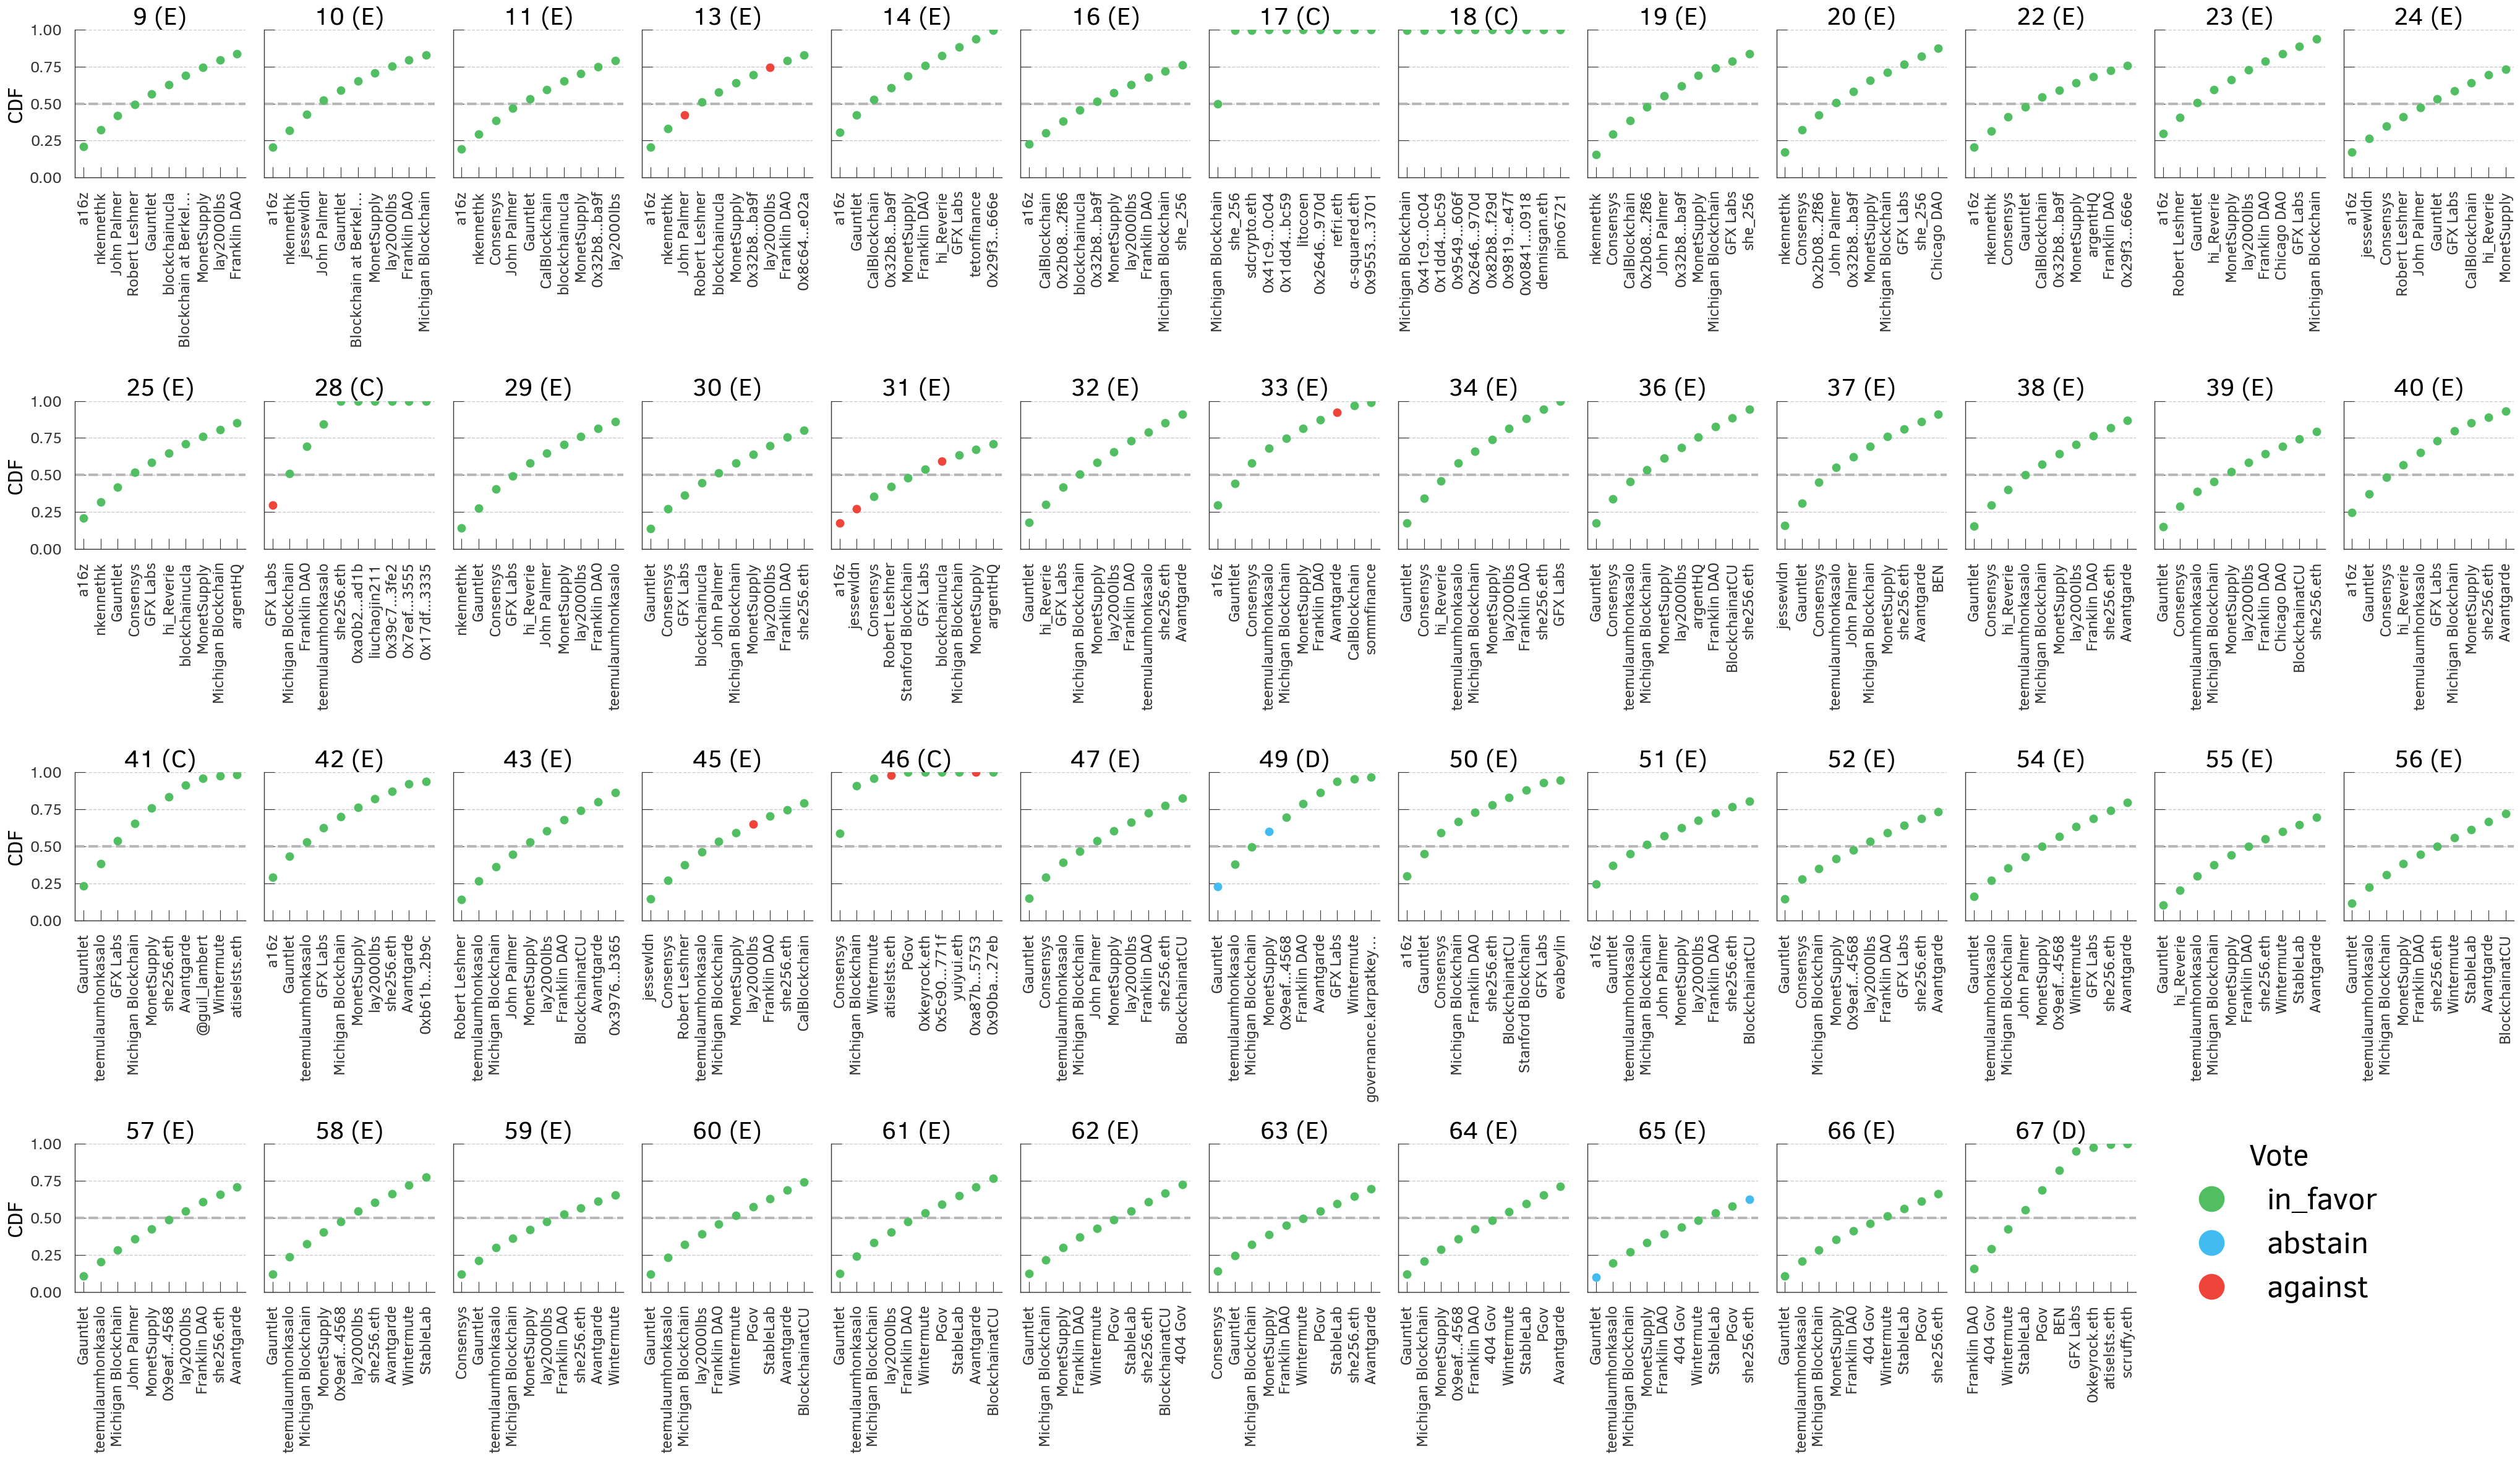

In [30]:
# Top 10 voters by number of weighted votes per proposal -- Cummulative voting distribution
import warnings
warnings.filterwarnings("ignore")

top_n = 10
top_voters_per_proposal_df = votes_df.copy()

top_voters_per_proposal_df['voter_label'] = top_voters_per_proposal_df['voter'].apply(
    lambda x: labels.get(x, x[:6]+"..."+x[-4:]))


top_voters_per_proposal_df['voter_label'] = top_voters_per_proposal_df.apply(
    lambda x: x['voter'][:6] + ' ... ' + x['voter'][-4:] if x['voter'] == x['voter_label'] else x['voter_label'], axis=1)
top_voters_per_proposal_df['votes_fraction'] = top_voters_per_proposal_df['votes'] / \
    top_voters_per_proposal_df.groupby('proposalId')['votes'].transform('sum')

top_voters_per_proposal_df['support'] = top_voters_per_proposal_df['support'].map(
    {0: 'against', 1: 'in_favor', 2: 'abstain'})

top_voters_per_proposal_df = top_voters_per_proposal_df.groupby('proposalId').apply(
    lambda x: x.sort_values(by='votes_fraction', ascending=False).head(top_n))[
        ['voter', 'votes', 'votes_fraction', 'support', 'voter_label']
].reset_index()

top_voters_per_proposal_df['votes_fraction_cum'] = top_voters_per_proposal_df.groupby(
    'proposalId')['votes_fraction'].cumsum()

top_voters_per_proposal_df['ranking'] = top_voters_per_proposal_df.groupby(
    'proposalId').votes_fraction.rank(method='first', ascending=False).astype(int)

top_voters_per_proposal_df.rename(
    columns={'proposalId': 'Proposal', 'voter_label': 'Top voters',
             'votes_fraction_cum': 'Votes fraction cum', 'support': 'Voter'},
    inplace=True)
data = top_voters_per_proposal_df.sort_values(by=['Proposal', 'ranking'])
display(data)

grid = sns.catplot(data.rename(columns={'Votes fraction cum': 'CDF'}).sort_values(by=['Proposal', 'ranking'], ascending=[
                   False, False]), x='ranking', y='CDF', col='Proposal',
                   col_wrap=13, hue='Voter', kind='strip', s=100, sharex=False, height=6, aspect=.5, palette=dict(
    in_favor=colors['green'], against=colors['red'], abstain=colors['blue']))

for axes in grid.axes.flatten():
    proposal_id = int(axes.get_title().split('=')[-1].strip())
    axes.set_xticklabels(data.query(
        'Proposal == @proposal_id')['Top voters'], rotation=90)
    axes.set_title(
        f'{proposal_id} ({proposal_status[proposal_id][0].upper()})')
    axes.axhline(y=0.5, color=colors['grey'],
                 linestyle='--', linewidth=3, zorder=1)
grid.set(ylim=(0, 1))
grid.set_axis_labels('')

sns.move_legend(grid, "upper center", ncol=1,
                bbox_to_anchor=(.9, 0.24), fontsize=36, markerscale=3, title='Vote', title_fontsize=35)

plt.tight_layout()

file_dir = os.path.join(
    plots_dir, "top_voters_per_proposal_tag_cum_{}.pdf".format(protocol_name))

plt.savefig(file_dir, bbox_inches='tight')

In [31]:
# Number of voters necessary to reach 50% of the total votes
# The plot shows the minimum number of voters necessary to reach 50% of the total votes for each proposal.
# We use a rolling window of 7 proposals to smooth the data.
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

groupped_data = top_voters_per_proposal_df.rename(
    columns={'Votes fraction cum': 'votes_fraction_cum'}
).reset_index(drop=True).set_index('Proposal').groupby(level='Proposal')
data = groupped_data.apply(lambda x: x.query(
    'votes_fraction_cum >= 0.5')['ranking'].min())
print("On average, it takes {} voters to reach 50% of the total votes.".format(
    data.mean().round(2)))
display(data.describe().to_frame().T)

data = data.to_frame().merge(proposals_created_timestamp_df[[
    'proposalId', 'proposal_created_timestamp']], left_on="Proposal", right_on="proposalId", how="left")
data.columns = ['min_voters', 'proposalId', 'timestamp']
data = data.set_index('timestamp').sort_index()

data_sample = data['min_voters'].resample(
    'W').last().ffill().rolling(window=20)

data_mean = data['min_voters'].resample(
    'W').mean().ffill().rolling(window=10).mean()
data_max = data['min_voters'].resample(
    'W').max().ffill().rolling(window=10).max()
data_min = data['min_voters'].resample(
    'W').min().ffill().rolling(window=10).min()
data_median = data['min_voters'].resample(
    'W').median().ffill().rolling(window=10).median()

fig.add_trace(go.Scatter(x=data_mean.index, y=data_mean, line=dict(
    color=colors['blue'], width=4, dash='solid'), mode='lines', name='Mean'))

fig.add_trace(go.Scatter(x=data_max.index, y=data_max, line=dict(
    color=colors['red'], width=3, dash='dash'), mode='lines', name='Max'))

fig.add_trace(go.Scatter(x=data_median.index, y=data_median, line=dict(
    color=colors['green'], width=3, dash='dot'), mode='lines', name='Median'))

fig.update_layout(
    yaxis_title="Nakamoto coefficient", xaxis_title="Date",
    legend=dict(xanchor='center', x=0.5, y=1.05, orientation='h'))

fig.update_xaxes(dtick="M4", tickformat="%b\n%Y",)

file_dir = os.path.join(
    plots_dir, "voting_power_to_reach_50_perc_of_votes_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

On average, it takes 4.7 voters to reach 50% of the total votes.


count  mean       std  min  25%  50%  75%  max
0   50.0   4.7  1.593994  1.0  4.0  5.0  6.0  8.0

In [32]:
# Number of voters necessary to reach 50% of the total votes
# The plot shows the minimum number of voters necessary to reach 50% of the total votes for each proposal.
# We use a rolling window of 7 proposals to smooth the data.
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

groupped_data = top_voters_per_proposal_df.rename(
    columns={'Votes fraction cum': 'votes_fraction_cum'}
).reset_index(drop=True).set_index('Proposal').groupby(level='Proposal')
data = groupped_data.apply(lambda x: x.query(
    'votes_fraction_cum >= 0.5')['ranking'].min())
print("On average, it takes {} voters to reach 50% of the total votes.".format(
    data.mean().round(2)))
display(data.describe().to_frame().T)

data = data.to_frame().merge(proposals_created_timestamp_df[[
    'proposalId', 'proposal_created_timestamp']], left_on="Proposal", right_on="proposalId", how="left")
data.columns = ['min_voters', 'proposalId', 'timestamp']
data = data.set_index('proposalId').sort_index()

fig.add_trace(go.Scatter(x=data.index, y=data['min_voters'].rolling(window=10).mean(), line=dict(
    color=colors['blue'], width=4), mode='lines'))

fig.update_layout(yaxis_title="Nakamoto coefficient", xaxis_title="Proposal ID",  xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_xaxes(range=[20, 70])
file_dir = os.path.join(
    plots_dir, "voting_power_to_reach_50_perc_of_votes_proposal_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

On average, it takes 4.7 voters to reach 50% of the total votes.


count  mean       std  min  25%  50%  75%  max
0   50.0   4.7  1.593994  1.0  4.0  5.0  6.0  8.0

In [33]:
top_voters_per_proposal_df.voter.unique().size

67

In [34]:
sum(list(map(lambda x: x in labels, top_voters_per_proposal_df.voter.unique())))

45

### Voting turnout


In [35]:
# Fraction of the voting participation each proposal received during the voting period

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

maker_colors = {'executed': colors['green'],
                'defeated': colors['red'], 'canceled': colors['blue']}

markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}

data = proposal_votes_df[['voting_participation_fraction', 'status']]
n_proposals = data.index.max()
display(data['voting_participation_fraction'].describe().to_frame().T)

for status in ['executed', 'defeated', 'canceled']:
    data = proposal_votes_df.query('status == @status')
    fig.add_trace(go.Scatter(x=data.index, y=100*data['voting_participation_fraction'],
                             mode='markers', name=status.capitalize(),
                             marker=dict(color=maker_colors[status], size=10, symbol=markers[status], opacity=0.7, line=dict(width=1, color='white'))))

moving_average = proposal_votes_df['voting_participation_fraction'].rolling(
    window=10).mean()

fig.add_trace(go.Scatter(x=moving_average.index, y=100*moving_average, line=dict(
    color=colors['brown'], width=2), mode='lines', name='Moving Average'))


fig.update_layout(yaxis_title="Participation percentage", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'), yaxis_ticksuffix="%")

fig.update_yaxes(range=[0, 100])
fig.update_xaxes(range=[-1, n_proposals+1])

file_dir = os.path.join(
    plots_dir, "voting_participation_fraction_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

count     mean       std  min      25%     50%  \
voting_participation_fraction   67.0  0.18077  0.128689  0.0  0.00615  0.2161   

                                 75%     max  
voting_participation_fraction  0.261  0.4058

### Voting Delay


In [36]:
file_dir = os.path.join(data_dir + "blocks",
                        "block_timestamp__9600000_20563001.csv.gz")
blocks_df = pd.read_csv(file_dir)
blocks_df['timestamp'] = pd.to_datetime(
    blocks_df['timestamp']).dt.tz_localize(None)
blocks_df.head()

number           timestamp
0  20563001 2024-08-19 13:34:11
1  20563000 2024-08-19 13:33:59
2  20562999 2024-08-19 13:33:47
3  20562998 2024-08-19 13:33:35
4  20562997 2024-08-19 13:33:23

In [37]:
# Compute the fraction of votes per hour
voting_period_duration_df = votes_df[['blockNumber', 'proposalId', 'votes', 'transactionIndex',
                                      'logIndex', 'support', 'voter', 'transactionHash']].rename(columns={'blockNumber': 'blockNumber_vote_cast'})
# It computes the time when the proposal was created
voting_period_duration_df = voting_period_duration_df.merge(proposal_created_df[['startBlock', 'proposalId']].rename(
    columns={'startBlock': 'blockNumber_voting_period_start'}), on='proposalId', how='left').dropna()

# It computes the time the voting period started
voting_period_duration_df = voting_period_duration_df.merge(blocks_df, left_on='blockNumber_voting_period_start', right_on='number',
                                                            how='left').rename(columns={'timestamp': 'timestamp_voting_period_start'}).drop(columns=['number'])
# It computes the time the votes were casted
voting_period_duration_df = voting_period_duration_df.merge(blocks_df, left_on='blockNumber_vote_cast', right_on='number',
                                                            how='left').rename(columns={'timestamp': 'timestamp_vote_cast'}).drop(columns=['number'])
# It computes the time it took for the votes to be casted
voting_period_duration_df['voting_delay'] = voting_period_duration_df['timestamp_vote_cast'] - \
    voting_period_duration_df['timestamp_voting_period_start']

# Include the proposal final status
voting_period_duration_df = voting_period_duration_df.merge(
    votes_weighted_df[['proposalId', 'status']], on='proposalId', how='left')

voting_period_duration_df.head()

blockNumber_vote_cast  proposalId         votes  transactionIndex  \
0               13553145           9  1.000007e+02                99   
1               13553257           9  2.500012e+06               145   
2               13554645           9  4.355769e+06               204   
3               13556434           9  2.544662e+02               314   
4               13556443           9  1.054247e+01               384   

   logIndex  support                                       voter  \
0       307        1  0xd724107ae1047b50b543ad4d940dee18e99261f1   
1       377        1  0x9b68c14e936104e9a7a24c712beecdc220002984   
2       343        1  0x458ceec48586a85fcfeb4a179706656ee321730e   
3       591        1  0xf4844a06d4f995c4c03195afcb5aa59dcbb5b4fc   
4       493        1  0xe87be8e831c019b1113f1ea5f8ffd9ba65828bf2   

                                     transactionHash  \
0  d1963da94947c2cd4f10867207fb5b12b08b242f120d8a...   
1  7f50b7474f5f003bdb6e6c0cd2310c94f70897fdeb8eac...   
2  862a063d162ee5cd4896c7f05be25cdcf80dfd925b62db...   
3  faf07fab6405c52eb78d53a2d53c6845679dda8cbbdc76...   
4  fdb14f0cbeb41fe03b468e102c12b41c32051c22c6b780...   

   blockNumber_voting_period_start timestamp_voting_period_start  \
0                         13551293           2021-11-04 16:31:23   
1                         13551293           2021-11-04 16:31:23   
2                         13551293           2021-11-04 16:31:23   
3                         13551293           2021-11-04 16:31:23   
4                         13551293           2021-11-04 16:31:23   

  timestamp_vote_cast    voting_delay    status  
0 2021-11-04 23:30:38 0 days 06:59:15  executed  
1 2021-11-05 00:00:27 0 days 07:29:04  executed  
2 2021-11-05 05:08:38 0 days 12:37:15  executed  
3 2021-11-05 11:52:33 0 days 19:21:10  executed  
4 2021-11-05 11:54:31 0 days 19:23:08  executed

In [38]:
voting_delay_df = voting_period_duration_df[[
    'proposalId', 'voting_delay', 'support', 'status']].reset_index(drop=True)
voting_delay_df['voting_delay_minute'] = voting_delay_df['voting_delay'].dt.total_seconds() / 60
voting_delay_df['voting_delay_hour'] = voting_delay_df['voting_delay'].dt.total_seconds() / \
    3600
voting_delay_df['voting_delay_day'] = voting_delay_df['voting_delay'].dt.total_seconds() / \
    3600 / 24
voting_delay_df.head()

proposalId    voting_delay  support    status  voting_delay_minute  \
0           9 0 days 06:59:15        1  executed           419.250000   
1           9 0 days 07:29:04        1  executed           449.066667   
2           9 0 days 12:37:15        1  executed           757.250000   
3           9 0 days 19:21:10        1  executed          1161.166667   
4           9 0 days 19:23:08        1  executed          1163.133333   

   voting_delay_hour  voting_delay_day  
0           6.987500          0.291146  
1           7.484444          0.311852  
2          12.620833          0.525868  
3          19.352778          0.806366  
4          19.385556          0.807731

In [39]:
# Voting cost per proposal
fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))

data = voting_delay_df.groupby('proposalId').voting_delay_day.median()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['brown'], width=2), mode='lines', name='median delay'))


data = voting_delay_df.query(
    'proposalId not in @proposals_defeated_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.voting_delay_day,
              name='Executed', marker_color=colors['green'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = voting_delay_df.query(
    'proposalId in @proposals_defeated_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.voting_delay_day,
              name='Defeated', marker_color=colors['red'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = voting_delay_df.query(
    'proposalId in @proposal_cancelled_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.voting_delay_day,
              name='Canceled', marker_color=colors['blue'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

fig.update_layout(yaxis_title="Voting gap (in days)", xaxis_title="Proposal ID",
                  xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

file_dir = os.path.join(
    plots_dir, "voting_delay_per_proposal_{}.pdf".format(protocol_name))

fig.write_image(file_dir, width=1540, height=380, scale=1)
fig.show(plot_style)

In [40]:
data = voting_delay_df.voting_delay_day.describe()
print("On average, it takes {} days for a proposal to be executed.".format(
    data['mean'].round(2)))
data.to_frame().T

On average, it takes 2.72 days for a proposal to be executed.


count      mean       std       min       25%       50%  \
voting_delay_day  51580.0  2.723806  1.712665  0.000694  1.319957  2.546655   

                       75%      max  
voting_delay_day  4.289722  7.26706

In [ ]:
bins = [0, 24, 48, 72, 96, 120, 144,
        voting_delay_df['voting_delay_hour'].max()]
text = ['up to 1 day', '1 to 2 days', '2 to 3 days',
        '3 to 4 days', '4 to 5 days', '5 to 6 days', '6+']
data = (100 * pd.cut(voting_delay_df['voting_delay_hour'],
        bins=bins).value_counts(normalize=True)).sort_index()

data_executed = (100 * pd.cut(voting_delay_df.query('status == "executed"')
                 ['voting_delay_hour'], bins=bins).value_counts(normalize=True)).sort_index()
data_defeated = (100 * pd.cut(voting_delay_df.query('status == "defeated"')
                 ['voting_delay_hour'], bins=bins).value_counts(normalize=True)).sort_index()
data_cancelled = (100 * pd.cut(voting_delay_df.query('status == "canceled"')
                  ['voting_delay_hour'], bins=bins).value_counts(normalize=True)).sort_index()

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
# All proposals
fig.add_trace(go.Bar(x=text, y=data.values,
              marker_color=colors['grey'], textposition='auto', text=data.values.round(2), name='All proposals'))
# Executed proposals
fig.add_trace(go.Bar(x=text, y=data_executed.values,
              marker_color=colors['green'], textposition='auto', text=data_executed.values.round(2), name='Executed'))
# Defeated proposals
fig.add_trace(go.Bar(x=text, y=data_defeated.values,
              marker_color=colors['red'], textposition='auto', text=data_defeated.values.round(2), name='Defeated'))
# Canceled proposals
# fig.add_trace(go.Bar(x=data_cancelled.index.astype('str'), y=data_cancelled.values,
#               marker_color=colors['blue'], textposition='auto', text=data_cancelled.values.round(2), name='Canceled'))

fig.update_layout(yaxis_title="Percentage of votes", xaxis_title="Voting gap",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'), yaxis_ticksuffix="%")

fig.update_yaxes(range=[0, 100])

file_dir = os.path.join(
    plots_dir, "voting_delay_distribution_{}.pdf".format(protocol_name))

fig.write_image(file_dir, width=width, height=height, scale=1)

fig.show(plot_style)

In [42]:
(voting_delay_df['voting_delay_hour']/24).describe()

count    51580.000000
mean         2.723806
std          1.712665
min          0.000694
25%          1.319957
50%          2.546655
75%          4.289722
max          7.267060
Name: voting_delay_hour, dtype: float64

In [43]:
voter_ts_df = votes_df[['blockNumber', 'transactionIndex',
                        'proposalId', 'support', 'votes', 'voter', 'transactionHash']]

voter_ts_df['voter_label'] = voter_ts_df['voter'].apply(
    lambda x: labels.get(x, x[:6]+"..."+x[-4:]))

voter_ts_df['votes_fraction'] = voter_ts_df['votes'] / \
    voter_ts_df.groupby('proposalId')['votes'].transform('sum')
voter_ts_df['support'] = voter_ts_df['support'].map(
    {0: 'against', 1: 'in_favor', 2: 'abstain'})

voter_ts_df = voter_ts_df.groupby('proposalId').apply(
    lambda x: x.sort_values(by='votes_fraction', ascending=False))[
        ['blockNumber', 'transactionIndex', 'voter', 'votes',
            'votes_fraction', 'support', 'voter_label', 'transactionHash']
].reset_index().drop(columns=['level_1'])

voter_ts_df['ranking'] = voter_ts_df.groupby(
    'proposalId').votes_fraction.rank(method='first', ascending=False).astype(int)

voter_ts_df = voter_ts_df.merge(
    blocks_df, left_on='blockNumber', right_on='number', how='left')

voter_ts_df.sort_values(by='timestamp', inplace=True)

voter_ts_df['votes_fraction_cum'] = voter_ts_df.groupby(
    'proposalId')['votes_fraction'].cumsum()

voter_ts_df.rename(
    columns={'proposalId': 'Proposal', 'blockNumber': 'block_number', 'support': 'Voter', 'transactionIndex': 'vote_position',
             'votes_fraction_cum': 'Votes fraction',  'voter_label': 'Top voters', },
    inplace=True)

voter_ts_df.sort_values(by='timestamp', inplace=True)

# Computed the voting delay per vote per proposal
voter_ts_df = voter_ts_df.merge(voting_period_duration_df[['blockNumber_vote_cast', 'proposalId', 'voting_delay']], left_on=['block_number', 'Proposal'], right_on=[
    'blockNumber_vote_cast', 'proposalId'], how='left').drop(columns=['blockNumber_vote_cast', 'proposalId', 'transactionHash']).drop_duplicates()

voter_ts_df['Voting delay'] = (
    voter_ts_df['voting_delay'].dt.total_seconds() / 3600/24)
voter_ts_df.head()

Proposal  block_number  vote_position  \
0         9      13553145             99   
1         9      13553257            145   
2         9      13554645            204   
3         9      13556434            314   
4         9      13556443            384   

                                        voter         votes  votes_fraction  \
0  0xd724107ae1047b50b543ad4d940dee18e99261f1  1.000007e+02    1.401164e-06   
1  0x9b68c14e936104e9a7a24c712beecdc220002984  2.500012e+06    3.502900e-02   
2  0x458ceec48586a85fcfeb4a179706656ee321730e  4.355769e+06    6.103102e-02   
3  0xf4844a06d4f995c4c03195afcb5aa59dcbb5b4fc  2.544662e+02    3.565462e-06   
4  0xe87be8e831c019b1113f1ea5f8ffd9ba65828bf2  1.054247e+01    1.477162e-07   

      Voter             Top voters  ranking    number           timestamp  \
0  in_favor          0xd724...61f1       29  13553145 2021-11-04 23:30:38   
1  in_favor             getty_hill       12  13553257 2021-11-05 00:00:27   
2  in_favor  Blockchain at Berkel…        7  13554645 2021-11-05 05:08:38   
3  in_favor           wijuwiju.eth       27  13556434 2021-11-05 11:52:33   
4  in_favor          0xe87b...8bf2       31  13556443 2021-11-05 11:54:31   

   Votes fraction    voting_delay  Voting delay  
0        0.000001 0 days 06:59:15      0.291146  
1        0.035030 0 days 07:29:04      0.311852  
2        0.096061 0 days 12:37:15      0.525868  
3        0.096065 0 days 19:21:10      0.806366  
4        0.096065 0 days 19:23:08      0.807731

Proposal  block_number  vote_position  \
0         9      13553145             99   
1         9      13553257            145   
2         9      13554645            204   
3         9      13556434            314   
4         9      13556443            384   

                                        voter         votes  votes_fraction  \
0  0xd724107ae1047b50b543ad4d940dee18e99261f1  1.000007e+02    1.401164e-06   
1  0x9b68c14e936104e9a7a24c712beecdc220002984  2.500012e+06    3.502900e-02   
2  0x458ceec48586a85fcfeb4a179706656ee321730e  4.355769e+06    6.103102e-02   
3  0xf4844a06d4f995c4c03195afcb5aa59dcbb5b4fc  2.544662e+02    3.565462e-06   
4  0xe87be8e831c019b1113f1ea5f8ffd9ba65828bf2  1.054247e+01    1.477162e-07   

      Voter             Top voters  ranking    number           timestamp  \
0  in_favor          0xd724...61f1       29  13553145 2021-11-04 23:30:38   
1  in_favor             getty_hill       12  13553257 2021-11-05 00:00:27   
2  in_favor  Blockchain at Berkel…        7  13554645 2021-11-05 05:08:38   
3  in_favor           wijuwiju.eth       27  13556434 2021-11-05 11:52:33   
4  in_favor          0xe87b...8bf2       31  13556443 2021-11-05 11:54:31   

   Votes fraction    voting_delay  Voting delay  
0        0.000001 0 days 06:59:15      0.291146  
1        0.035030 0 days 07:29:04      0.311852  
2        0.096061 0 days 12:37:15      0.525868  
3        0.096065 0 days 19:21:10      0.806366  
4        0.096065 0 days 19:23:08      0.807731

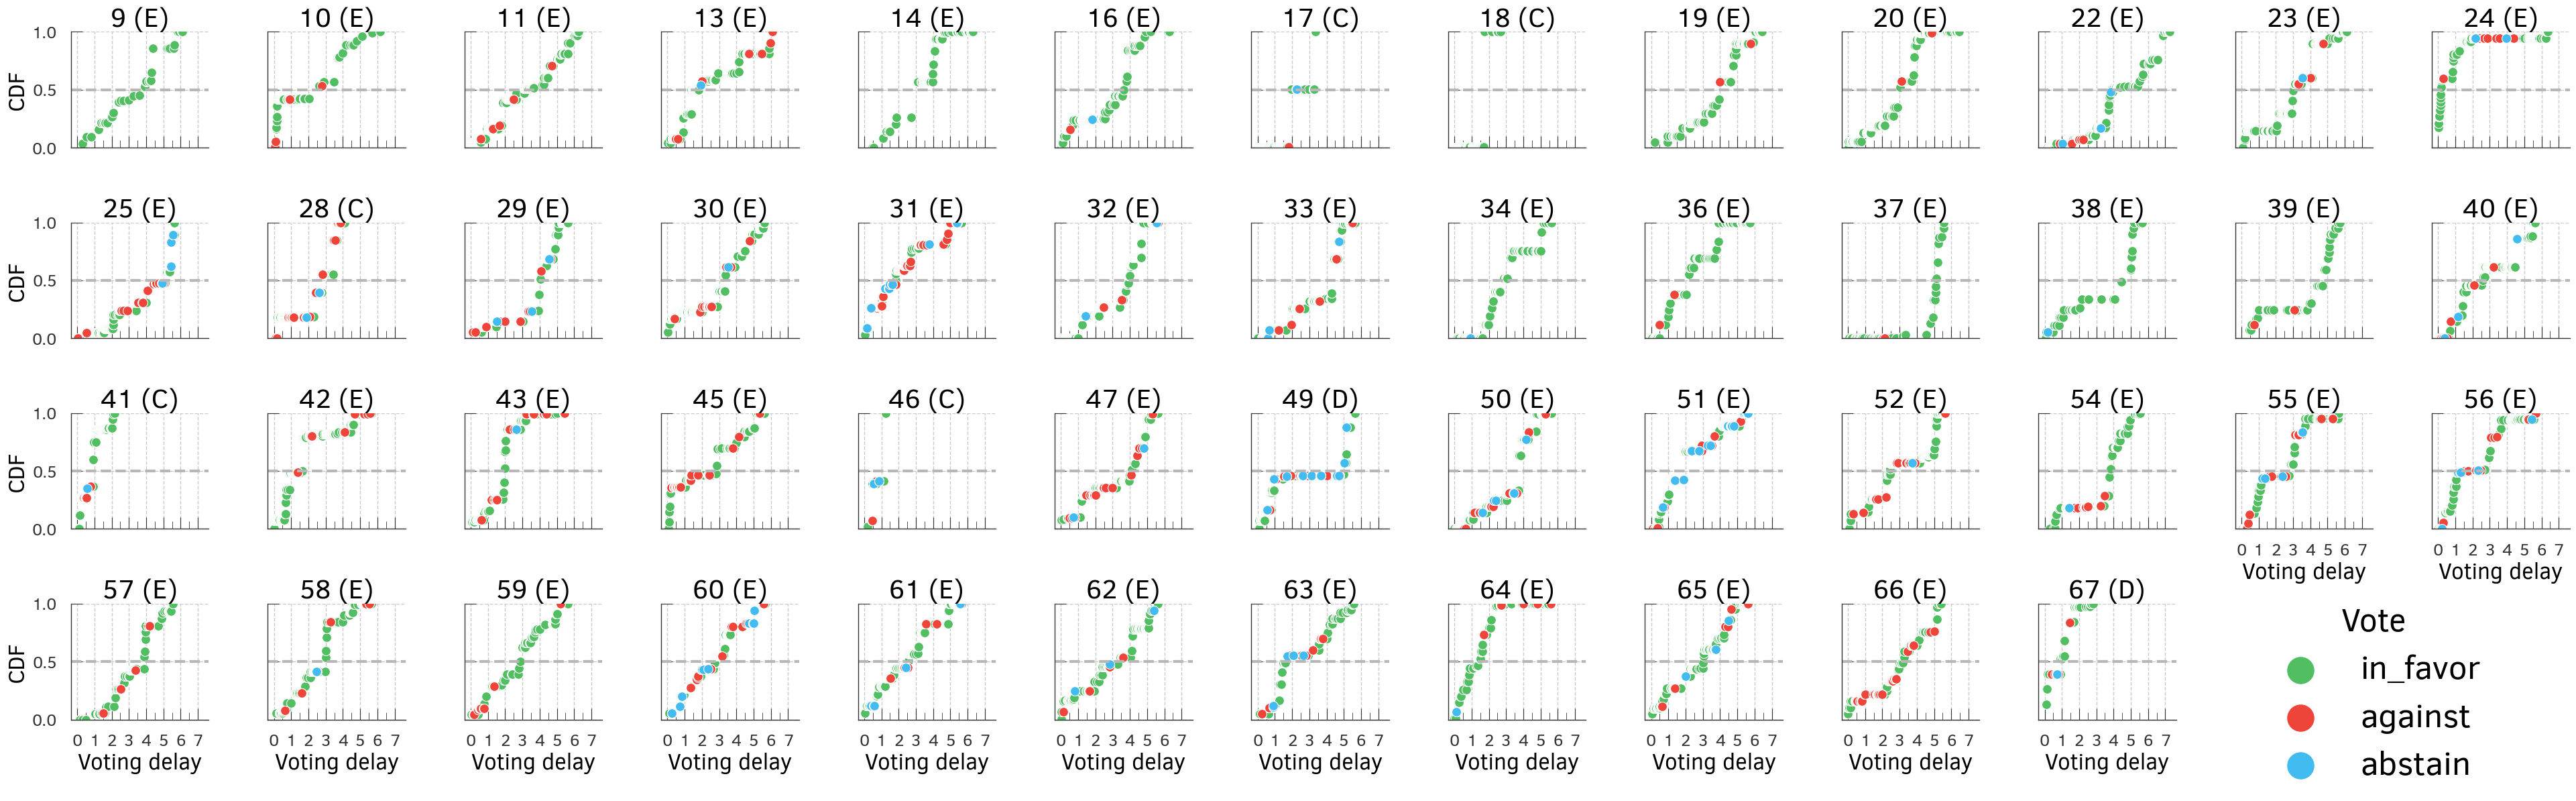

In [44]:
# Convert the timestamp to the minutes/hours it passed since the voting period began
display(voter_ts_df.head())

grid = sns.FacetGrid(voter_ts_df.rename(columns={'Votes fraction': 'CDF'}),
                     col="Proposal", col_wrap=13, hue='Voter', palette=dict(
                         in_favor=colors['green'], against=colors['red'], abstain=colors['blue']))

grid.map(sns.scatterplot, "Voting delay", "CDF", s=100)

grid.set(ylim=(0, 1))

for axes in grid.axes.flatten():
    axes.axhline(y=0.5, color=colors['grey'],
                 linestyle='--', linewidth=3, zorder=1)
    axes.set_xticks(np.arange(0, 7+1, 1))
    axes.set_xticks(np.arange(0.5, 7, .5), minor=True)
    axes.tick_params(axis='x', which='both')
    proposal_id = int(axes.get_title().split('=')[-1].strip())
    axes.set_title(
        f'{proposal_id} ({proposal_status[proposal_id][0].upper()})')

grid.add_legend(title="Vote")
sns.move_legend(grid, "upper center", ncol=1,
                bbox_to_anchor=(.87, 0.27), fontsize=36, markerscale=3, title='Vote', title_fontsize=35)

file_dir = os.path.join(
    plots_dir, "voting_delay_day_per_proposal_{}.pdf".format(protocol_name))
plt.savefig(file_dir, bbox_inches='tight')

In [45]:
# Average voting delay per day
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

groupped_data = voter_ts_df.reset_index(drop=True).set_index(
    'Proposal').groupby(level='Proposal')
data = groupped_data['voting_delay'].mean().dt.total_seconds() / 3600 / 24
print("On average, it takes voters {} days to cast their votes.".format(
    data.mean().round(2)))
display(data.describe().to_frame().T)

data = data.to_frame().merge(proposals_created_timestamp_df[[
    'proposalId', 'proposal_created_timestamp']], left_on="Proposal", right_on="proposalId", how="left")
data.columns = ['voting_delay', 'proposalId', 'timestamp']
data = data.set_index('timestamp').sort_index()
data = data['voting_delay'].resample(
    'W').last().ffill().rolling(window=20).mean()

fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['blue'], width=4), mode='lines'))

fig.update_layout(
    yaxis_title="Voting delay (days)", xaxis_title="Date")

fig.update_xaxes(dtick="M4", tickformat="%b\n%Y",)

file_dir = os.path.join(
    plots_dir, "avg_vote_delay_per_day_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

On average, it takes voters 2.51 days to cast their votes.


count      mean       std       min       25%       50%  \
voting_delay   50.0  2.505749  0.852262  0.679844  1.925323  2.711236   

                   75%       max  
voting_delay  3.163796  4.192114

In [46]:
# Average voting delay per proposal
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

groupped_data = voter_ts_df.reset_index(drop=True).set_index(
    'Proposal').groupby(level='Proposal')
data = groupped_data['voting_delay'].mean().dt.total_seconds() / 3600 / 24
print("On average, it takes voters {} days to cast their votes.".format(
    data.mean().round(2)))
display(data.describe().to_frame().T)

data = data.to_frame().merge(proposals_created_timestamp_df[[
    'proposalId', 'proposal_created_timestamp']], left_on="Proposal", right_on="proposalId", how="left")
data.columns = ['voting_delay', 'proposalId', 'timestamp']
data = data.set_index('proposalId').sort_index()

fig.add_trace(go.Scatter(x=data.index, y=data['voting_delay'].rolling(window=10).mean(),
                         line=dict(
    color=colors['blue'], width=4), mode='lines'))

fig.update_layout(yaxis_title="Voting delay (days)", xaxis_title="Proposal ID",  xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_xaxes(range=[20, 70])

file_dir = os.path.join(
    plots_dir, "avg_vote_delay_per_proposal_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

On average, it takes voters 2.51 days to cast their votes.


count      mean       std       min       25%       50%  \
voting_delay   50.0  2.505749  0.852262  0.679844  1.925323  2.711236   

                   75%       max  
voting_delay  3.163796  4.192114

### Quorum


In [47]:
# Number of voters that voted in favor of the proposal and the number of voters that voted against the proposal and reached the quorum
data = voter_ts_df.query('(Proposal in @proposal_executed_df.proposalId) and (Voter == "in_favor")').groupby(
    'Proposal').apply(lambda x: x.sort_values(by='votes', ascending=False)).reset_index(drop=True)
data['votes_cum'] = data.groupby(
    'Proposal')['votes'].cumsum()

data['ranking'] = data.groupby(
    'Proposal').votes_cum.rank(method='first', ascending=True).astype(int)

data = data.groupby('Proposal').apply(lambda x: x.query(
    'votes_cum >= @proposal_quorum')['ranking'].min())

display(data.describe().to_frame().T)

count      mean       std  min  25%   50%   75%   max
0   43.0  9.767442  3.228129  5.0  7.0  10.0  12.0  19.0

In [48]:
# It computes how long did it take for the proposal to reach quorum
quorum_df = votes_df.set_index('proposalId').groupby(level='proposalId').apply(lambda x: x.query('support == 1').sort_values(
    by=['blockNumber', 'transactionIndex', 'logIndex'],
    ascending=[True, True, True]).set_index('blockNumber').votes.cumsum().where(lambda x: x >= proposal_quorum).dropna().head(1)
).reset_index().rename(columns={'blockNumber': 'quorum_block_number'})

# It computes the time when the proposal was created
quorum_df = quorum_df.merge(proposal_created_df[['startBlock', 'proposalId']].rename(
    columns={'startBlock': 'blockNumber_start'}), on='proposalId', how='left').dropna()

# It computes the time when the proposal reached quorum
quorum_df = quorum_df.merge(blocks_df, left_on='quorum_block_number', right_on='number',
                            how='left').rename(columns={'timestamp': 'quorum_timestamp'})

quorum_df = quorum_df.merge(
    votes_weighted_df[['proposalId', 'status']], on='proposalId', how='left')

# It computes the time when the proposal was created
quorum_df = quorum_df.merge(blocks_df, left_on='blockNumber_start', right_on='number',
                            how='left').rename(columns={'timestamp': 'proposal_created_timestamp'})
quorum_df.drop(columns=['votes', 'number_x', 'number_y'], inplace=True)
quorum_df['time_to_quorum'] = (quorum_df['quorum_timestamp'] -
                               quorum_df['proposal_created_timestamp']).dt.total_seconds()/3600/24
quorum_df['block_to_quorum'] = quorum_df['quorum_block_number'] - \
    quorum_df['blockNumber_start']
quorum_df.head()

proposalId  quorum_block_number  blockNumber_start    quorum_timestamp  \
0           9             13576856           13551293 2021-11-08 16:30:58   
1          10             13805370           13786993 2021-12-14 20:09:36   
2          11             14337257           14310597 2022-03-07 03:13:54   
3          13             14457797           14431166 2022-03-25 21:21:08   
4          14             14535188           14508719 2022-04-06 23:07:55   

     status proposal_created_timestamp  time_to_quorum  block_to_quorum  
0  executed        2021-11-04 16:31:23        3.999711            25563  
1  executed        2021-12-12 00:00:50        2.839421            18377  
2  executed        2022-03-02 23:45:36        4.144653            26660  
3  executed        2022-03-21 17:55:16        4.142963            26631  
4  executed        2022-04-02 19:55:28        4.133646            26469

In [49]:
maker_colors = {'executed': colors['green'],
                'defeated': colors['red'], 'canceled': colors['blue']}

markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}

data = quorum_df.set_index('proposal_created_timestamp').time_to_quorum

fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['grey'], width=2), mode='lines', name='# days', marker_size=5))

data = data.resample('ME').mean()

fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['blue'], width=4), mode='lines', name='Monthly average', marker_size=10))


for status in ['executed', 'defeated', 'canceled']:
    data = quorum_df.query('(status == @status)').reset_index(drop=True)
    data['text'] = "Proposal #" + data['proposalId'].astype(str)
    fig.add_trace(go.Scatter(x=quorum_df.query('status==@status')['proposal_created_timestamp'],
                             y=[-0.04]*len(quorum_df),
                             mode='markers', name=status.capitalize(),
                             marker=dict(
        color=maker_colors[status], size=15, opacity=0.7, symbol=markers[status], line=dict(width=1, color='white')
    ), text=data['text']))


fig.update_layout(
    xaxis_title='Proposal creation time',
    yaxis_title='Days to reach quorum',
    legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'),
    yaxis=dict(tickmode='linear', tick0=0, dtick=1)
)
fig.update_xaxes(dtick="M2", tickformat="%b\n%Y",
                 range=[quorum_df.proposal_created_timestamp.min()-pd.Timedelta('3W'),
                        quorum_df.proposal_created_timestamp.max()+pd.Timedelta('3W')])
fig.update_yaxes(range=[-0.2, 6.1])

file_dir = os.path.join(
    plots_dir, "time_to_quorum_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=350, scale=1)

fig.show(plot_style)

In [50]:
data = quorum_df.set_index(
    'proposal_created_timestamp').time_to_quorum.describe()
print("On average, it takes {} days for a proposal to reach quorum.".format(
    data['mean'].round(2)))
data.to_frame().T

On average, it takes 4.15 days for a proposal to reach quorum.


count     mean      std       min       25%       50%  \
time_to_quorum   43.0  4.14699  1.11468  0.178519  3.882888  4.471944   

                     75%      max  
time_to_quorum  4.906944  5.66463

### Voting Cost


In [51]:
from plot_utils import plot_ohlc

In [52]:
file_dir = os.path.join(data_dir + "transactions_of_votes.csv.gz")
votes_transactions_df = pd.read_csv(file_dir)
votes_transactions_df['timestamp'] = pd.to_datetime(
    votes_transactions_df['timestamp'])
votes_transactions_df.head()

tx_hash  tx_block_number  \
0  43cf2f48d2d77816123fb95bc8aa7394cd6d06b7ee219f...         15703859   
1  c8b44a55e5d9a2593bc110b63362c3d84e5a1fee041575...         17996706   
2  9dfeb0296e685b3a15fa407715583732045bb9a81e6e3d...         19507380   
3  dad8a397ed3725c5ae2febd0f9f128c6ab01f17435718a...         10226261   
4  f69da2f52f4e3b6f2797ac40a9d1edf21d0ef9802cbd4d...         13225977   

   tx_effective_gas_price  tx_gas_used  tx_fee_eth           timestamp  
0              7546215611        79856    0.000603 2022-10-08 14:05:59  
1             12168780679        79856    0.000972 2023-08-26 05:16:47  
2             17965880351        79984    0.001437 2024-03-24 22:32:23  
3             30500000000        63134    0.001926 2020-06-08 16:45:48  
4             68000000000        80554    0.005478 2021-09-14 20:23:28

In [53]:
file_fir = os.path.join(data_dir, "yahoo_price_eth_usd.csv")
yahoo_price_df = pd.read_csv(file_fir)
yahoo_price_df.columns = [column.lower() for column in yahoo_price_df.columns]
yahoo_price_df['date'] = pd.to_datetime(yahoo_price_df['date'])
yahoo_price_df.head()

date        open        high         low       close   adj close  \
0 2017-11-09  308.644989  329.451996  307.056000  320.884003  320.884003   
1 2017-11-10  320.670990  324.717987  294.541992  299.252991  299.252991   
2 2017-11-11  298.585999  319.453003  298.191986  314.681000  314.681000   
3 2017-11-12  314.690002  319.153015  298.513000  307.907990  307.907990   
4 2017-11-13  307.024994  328.415009  307.024994  316.716003  316.716003   

       volume  
0   893249984  
1   885985984  
2   842300992  
3  1613479936  
4  1041889984

In [54]:
data = yahoo_price_df.set_index('date')['2020-06-01':]

fig = plot_ohlc(data[['open', 'high', 'low', 'close']])
sma = data['close'].rolling(min_periods=1, window=1,
                            center=False).mean().resample('10D').last()
fig.update_layout(
    get_plotly_layout(width=width, height=height),
    showlegend=True,
    legend=dict(xanchor='center', x=0.9, y=.95, orientation='h')
)
fig.add_trace(go.Scatter(x=sma.index, y=sma, mode='lines',
              name='Price', line=dict(color=colors['blue'], width=4)))

fig.update_xaxes(dtick="M4", tickformat="%b\n%Y",)

file_dir = os.path.join(plots_dir, "yahoo_price_eth_usd.pdf")
fig.write_image(file_dir, width=width, height=height)
fig.show(plot_style)

In [55]:
votes_cost_df = votes_df[['blockNumber', 'transactionHash', 'transactionIndex',
                          'logIndex', 'proposalId', 'votes', 'voter']]
votes_cost_df = votes_cost_df.merge(votes_transactions_df[['tx_hash', 'timestamp', 'tx_effective_gas_price', 'tx_gas_used',
                                    'tx_fee_eth']], left_on='transactionHash', right_on='tx_hash', how='left').drop(columns=['tx_hash'])
votes_cost_df['timestamp'] = pd.to_datetime(
    votes_cost_df['timestamp'].dt.strftime('%Y-%m-%d'))
votes_cost_df = votes_cost_df.merge(yahoo_price_df[['date', 'close']].rename(columns={
                                    'close': 'price_usd'}), left_on='timestamp', right_on='date', how='left').drop(columns=['date'])
votes_cost_df['tx_fee_usd'] = votes_cost_df['tx_fee_eth'] * \
    votes_cost_df['price_usd']
votes_cost_df['cost_normalized_per_vote'] = votes_cost_df['tx_fee_usd'] / \
    votes_cost_df['votes']
votes_cost_df.head()

blockNumber                                    transactionHash  \
0     13553145  d1963da94947c2cd4f10867207fb5b12b08b242f120d8a...   
1     13553257  7f50b7474f5f003bdb6e6c0cd2310c94f70897fdeb8eac...   
2     13554645  862a063d162ee5cd4896c7f05be25cdcf80dfd925b62db...   
3     13556434  faf07fab6405c52eb78d53a2d53c6845679dda8cbbdc76...   
4     13556443  fdb14f0cbeb41fe03b468e102c12b41c32051c22c6b780...   

   transactionIndex  logIndex  proposalId         votes  \
0                99       307           9  1.000007e+02   
1               145       377           9  2.500012e+06   
2               204       343           9  4.355769e+06   
3               314       591           9  2.544662e+02   
4               384       493           9  1.054247e+01   

                                        voter  timestamp  \
0  0xd724107ae1047b50b543ad4d940dee18e99261f1 2021-11-04   
1  0x9b68c14e936104e9a7a24c712beecdc220002984 2021-11-05   
2  0x458ceec48586a85fcfeb4a179706656ee321730e 2021-11-05   
3  0xf4844a06d4f995c4c03195afcb5aa59dcbb5b4fc 2021-11-05   
4  0xe87be8e831c019b1113f1ea5f8ffd9ba65828bf2 2021-11-05   

   tx_effective_gas_price  tx_gas_used  tx_fee_eth    price_usd  tx_fee_usd  \
0             85789334201        96956    0.008318  4537.324219   37.740513   
1            149579913345        79856    0.011945  4486.243164   53.587518   
2            105373654402        79856    0.008415  4486.243164   37.750474   
3             78915032625        79856    0.006302  4486.243164   28.271581   
4             89278992945        79856    0.007129  4486.243164   31.984506   

   cost_normalized_per_vote  
0                  0.377402  
1                  0.000021  
2                  0.000009  
3                  0.111102  
4                  3.033873

In [56]:
# Voting cost per proposal
fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))

display(votes_cost_df.tx_fee_usd.describe().to_frame().T)
print("All proposals cost a total of ${} in fees.".format(
    votes_cost_df.tx_fee_usd.sum().round(2)))

data = votes_cost_df.groupby('proposalId').tx_fee_usd.sum()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['light_purple'], width=4), mode='lines', name='total cost'))

data = votes_cost_df.groupby('proposalId').tx_fee_usd.median()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['brown'], width=2), mode='lines', name='median cost'))

data = votes_cost_df.query(
    'proposalId not in @proposals_defeated_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.tx_fee_usd,
              name='Executed', marker_color=colors['green'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_cost_df.query(
    'proposalId in @proposals_defeated_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.tx_fee_usd,
              name='Defeated', marker_color=colors['red'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_cost_df.query(
    'proposalId in @proposal_cancelled_df.proposalId')
fig.add_trace(go.Box(x=data.proposalId, y=data.tx_fee_usd,
              name='Cancelled', marker_color=colors['blue'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

fig.update_layout(yaxis_title="Voting cost (in USD)", xaxis_title="Proposal ID", xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_yaxes(type='log')

file_dir = os.path.join(
    plots_dir, "voting_cost_per_proposal_boxplot_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=380, scale=1)
fig.show(plot_style)

count      mean       std       min       25%       50%     75%  \
tx_fee_usd  51580.0  2.415113  2.555003  0.166055  1.187848  1.829516  2.6808   

                   max  
tx_fee_usd  126.864742

All proposals cost a total of $124571.51 in fees.


In [57]:
# Voting cost per proposal

# maker_colors = {'executed': colors['green'],
#                 'defeated': colors['red'], 'canceled': colors['blue']}

# markers = {'executed': 'circle', 'defeated': 'x', 'canceled': 'diamond-tall'}


# Voting cost per proposal
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

display(votes_cost_df.tx_fee_usd.describe().to_frame().T)
print("All proposals cost a total of ${} in fees.".format(
    votes_cost_df.tx_fee_usd.sum().round(2)))

data = votes_cost_df.groupby('proposalId').tx_fee_usd.sum()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['light_purple'], width=4), mode='lines', name='total cost'))

data = votes_cost_df.groupby('proposalId').tx_fee_usd.median()
fig.add_trace(go.Scatter(x=data.index, y=data, line=dict(
    color=colors['brown'], width=2), mode='lines', name='median cost'))

# for status in ['executed', 'defeated', 'canceled']:
#     data = proposals_created_timestamp_df.query(
#         'status == @status').reset_index()
#     data['text'] = "Proposal #" + data['proposalId'].astype(str)
#     fig.add_trace(go.Scatter(x=proposals_created_timestamp_df.query('status==@status')['proposalId'],
#                              y=[0.2]*len(proposals_created_timestamp_df),
#                              mode='markers', name=status.capitalize(),
#                              marker=dict(
#         color=maker_colors[status], size=15, opacity=0.7, symbol=markers[status], line=dict(width=1, color='white')
#     ), text=data['text']))


fig.update_layout(yaxis_title="Voting cost (in USD)", xaxis_title="Proposal ID", xaxis=dict(tickmode='linear', tick0=0, dtick=10, range=[0, proposal_created_df.proposalId.max()]),
                  yaxis=dict(tickmode='linear', tick0=0, dtick=1),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_yaxes(type='log')

file_dir = os.path.join(
    plots_dir, "voting_cost_per_proposal_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

count      mean       std       min       25%       50%     75%  \
tx_fee_usd  51580.0  2.415113  2.555003  0.166055  1.187848  1.829516  2.6808   

                   max  
tx_fee_usd  126.864742

All proposals cost a total of $124571.51 in fees.


In [58]:
# Distribution of the voting cost per proposal
votes_cost_df.groupby('proposalId').tx_fee_usd.sum().describe().to_frame().T

count         mean          std        min         25%  \
tx_fee_usd   50.0  2491.430296  2532.248726  22.575341  755.197477   

                    50%          75%           max  
tx_fee_usd  1784.428512  3211.032681  13059.299063

In [59]:
# Normalized voting cost per proposal

min_votes = 1e-6

fig = go.Figure(layout=get_plotly_layout(width=1540, height=350))

data = votes_cost_df.query(
    '(proposalId not in @proposals_defeated_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.cost_normalized_per_vote,
              name='Executed', marker_color=colors['green'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_cost_df.query(
    '(proposalId in @proposals_defeated_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.cost_normalized_per_vote,
              name='Defeated', marker_color=colors['red'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

data = votes_cost_df.query(
    '(proposalId in @proposal_cancelled_df.proposalId) and (votes >= @min_votes)')
fig.add_trace(go.Box(x=data.proposalId, y=data.cost_normalized_per_vote,
              name='Canceled', marker_color=colors['blue'], line=dict(width=1.5), whiskerwidth=0.5, fillcolor=colors['white']))

fig.update_layout(yaxis_title="Cost per vote unit (USD)", xaxis_title="Proposal ID", xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                  legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.update_yaxes(type='log')

file_dir = os.path.join(
    plots_dir, "voting_cost_per_proposal_normalized_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=380, scale=1)
fig.show(plot_style)

In [60]:
# Distribution of the normalized voting cost per proposal
data['cost_normalized_per_vote'].describe().to_frame().T

count        mean          std           min  \
cost_normalized_per_vote  3501.0  102.464521  2814.794262  3.106080e-07   

                               25%      50%       75%            max  
cost_normalized_per_vote  0.694296  1.74517  4.568961  104014.872676

### Vote Similarity


In [61]:
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [62]:
from plot_utils import plot_heatmap_votes, plot_heatmap

In [63]:
voter_df = votes_df[['proposalId', 'voter', 'support']].reset_index(drop=True)
voter_df['voter_label'] = voter_df['voter'].apply(
    lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
voter_df.head()

proposalId                                       voter  support  \
0           9  0xd724107ae1047b50b543ad4d940dee18e99261f1        1   
1           9  0x9b68c14e936104e9a7a24c712beecdc220002984        1   
2           9  0x458ceec48586a85fcfeb4a179706656ee321730e        1   
3           9  0xf4844a06d4f995c4c03195afcb5aa59dcbb5b4fc        1   
4           9  0xe87be8e831c019b1113f1ea5f8ffd9ba65828bf2        1   

             voter_label  
0          0xd724...61f1  
1             getty_hill  
2  Blockchain at Berkel…  
3           wijuwiju.eth  
4          0xe87b...8bf2

In [64]:
# Voters who votred on more proposals
voter_df['voter_label'].value_counts().head()

voter_label
Michigan Blockchain    46
MonetSupply            42
GFX Labs               41
Franklin DAO           39
Gauntlet               38
Name: count, dtype: int64

In [65]:
n_votes = 10
top_voters = voter_df['voter_label'].value_counts()
top_voters = top_voters[top_voters >= n_votes].index
print("There are {} ({}%) out of {} voters with at least {} votes".format(len(top_voters),
      round(100*len(top_voters)/voter_df['voter_label'].nunique(), 2), voter_df.voter.nunique(), n_votes))

There are 613 (2.96%) out of 20695 voters with at least 10 votes


In [66]:
votes_vector = voter_df.query('voter_label in @top_voters')[['proposalId', 'support', 'voter_label']].pivot_table(
    index='voter_label', columns='proposalId', values='support').loc[top_voters]

missing_proposals = set(votes_weighted_df.proposalId) - \
    set(votes_vector.columns)
print("There are {} missing proposals".format(len(missing_proposals)))
print(sorted(missing_proposals))
for proposalId in missing_proposals:
    votes_vector[proposalId] = np.nan
votes_vector = votes_vector[votes_weighted_df.proposalId]

There are 17 missing proposals
[1, 2, 3, 4, 5, 6, 7, 8, 12, 15, 21, 26, 27, 35, 44, 48, 53]


In [67]:
# Plot how each of the top 15 voters (based on # of proposals voted) voted on each proposal
fig = plot_heatmap_votes(
    df=votes_vector.head(15), xgap=1, ygap=1)

fig.update_layout(yaxis=dict(tickfont=dict(size=12.9)))

fig.update_xaxes(range=[8, votes_vector.columns.size+1],
                 tickmode='linear', tick0=0, dtick=10)

file_dir = os.path.join(
    plots_dir, "heatmap_votes_top_voters_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

In [68]:
proposal_ids = sorted(set(votes_vector.columns) - set(missing_proposals))
data = votes_vector[proposal_ids]+1
cosine_df = pd.DataFrame(cosine_similarity(
    data.fillna(0)), index=data.index, columns=data.index)
cosine_df.head()

voter_label          Michigan Blockchain  MonetSupply  GFX Labs  Franklin DAO  \
voter_label                                                                     
Michigan Blockchain             1.000000     0.885575  0.844549      0.826336   
MonetSupply                     0.885575     1.000000  0.870985      0.840028   
GFX Labs                        0.844549     0.870985  1.000000      0.815303   
Franklin DAO                    0.826336     0.840028  0.815303      1.000000   
Gauntlet                        0.834058     0.878085  0.875068      0.830336   

voter_label          Gauntlet  Wintermute  BenthamDaemon  teemulaumhonkasalo  \
voter_label                                                                    
Michigan Blockchain  0.834058    0.794441       0.767959            0.794441   
MonetSupply          0.878085    0.723722       0.737377            0.778343   
GFX Labs             0.875068    0.785875       0.657277            0.800163   
Franklin DAO         0.830336    0.690237       0.747757            0.718997   
Gauntlet             1.000000    0.790223       0.663223            0.790223   

voter_label          BlockchainatCU  she256.eth  ...  0xf4aa...a26c  \
voter_label                                      ...                  
Michigan Blockchain        0.776968    0.764017  ...       0.373002   
MonetSupply                0.745058    0.760286  ...       0.384678   
GFX Labs                   0.735493    0.795557  ...       0.301893   
Franklin DAO               0.784604    0.684184  ...       0.303822   
Gauntlet                   0.697302    0.778532  ...       0.198762   

voter_label          0x187d...cba9  0x0683...87cb  0xbefe...bfd7  \
voter_label                                                        
Michigan Blockchain       0.373002       0.373002       0.373002   
MonetSupply               0.384678       0.384678       0.384678   
GFX Labs                  0.301893       0.301893       0.301893   
Franklin DAO              0.303822       0.303822       0.303822   
Gauntlet                  0.198762       0.198762       0.198762   

voter_label          0x91d3...216d  0x7430...adf5  0x0b49...893f  \
voter_label                                                        
Michigan Blockchain       0.373002       0.373002       0.373002   
MonetSupply               0.384678       0.384678       0.384678   
GFX Labs                  0.301893       0.301893       0.301893   
Franklin DAO              0.303822       0.303822       0.303822   
Gauntlet                  0.198762       0.198762       0.198762   

voter_label          0x11d7...436f  0xf66c...98a1  0x43ef...68de  
voter_label                                                       
Michigan Blockchain       0.373002       0.373002       0.373002  
MonetSupply               0.384678       0.384678       0.384678  
GFX Labs                  0.301893       0.301893       0.301893  
Franklin DAO              0.303822       0.303822       0.303822  
Gauntlet                  0.198762       0.198762       0.198762  

[5 rows x 613 columns]

In [69]:
fig = plot_heatmap(
    cosine_df.head(15),
    freq_text="Cosine similarity",  font_size_z=12,  annotation=True)

fig.update_layout(yaxis=dict(tickfont=dict(size=12)))
fig.update_traces(showscale=False)

file_dir = os.path.join(
    plots_dir, "cosine_similarity_top_voters_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=1540, height=380, scale=1)
fig.show(plot_style)

In [70]:
voter_df.query('(voter_label in @top_voters) and (support == 1)')[['proposalId', 'support', 'voter_label']].pivot_table(
    index='voter_label', columns='proposalId', values='support').loc[top_voters]

proposalId            9    10   11   13   14   16   17   18   19   20  ...  \
voter_label                                                            ...   
Michigan Blockchain  1.0  1.0  NaN  1.0  NaN  1.0  1.0  1.0  1.0  1.0  ...   
MonetSupply          1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  1.0  1.0  ...   
GFX Labs             NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  1.0  1.0  ...   
Franklin DAO         1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  ...   
Gauntlet             1.0  1.0  1.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  ...   
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
0x7430...adf5        NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
0x0b49...893f        NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
0x11d7...436f        NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
0xf66c...98a1        NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
0x43ef...68de        NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   

proposalId            58   59   60   61   62   63   64   65   66   67  
voter_label                                                            
Michigan Blockchain  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  
MonetSupply          1.0  1.0  NaN  NaN  1.0  1.0  1.0  1.0  1.0  NaN  
GFX Labs             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Franklin DAO         NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Gauntlet             1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  1.0  NaN  
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
0x7430...adf5        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
0x0b49...893f        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
0x11d7...436f        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
0xf66c...98a1        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
0x43ef...68de        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[613 rows x 50 columns]

In [71]:
data_votes = voter_df.query('voter_label in @top_voters')[['proposalId', 'support', 'voter_label']].pivot_table(
    index='voter_label', columns='proposalId', values='support').loc[top_voters]
data_votes = data_votes.clip(0, 1).fillna(0)
data_votes.head()

proposalId            9    10   11   13   14   16   17   18   19   20  ...  \
voter_label                                                            ...   
Michigan Blockchain  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  ...   
MonetSupply          1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  ...   
GFX Labs             0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  ...   
Franklin DAO         1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   
Gauntlet             1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   

proposalId            58   59   60   61   62   63   64   65   66   67  
voter_label                                                            
Michigan Blockchain  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  
MonetSupply          1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  
GFX Labs             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Franklin DAO         0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Gauntlet             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  

[5 rows x 50 columns]

In [72]:
cosine_df = pd.DataFrame(cosine_similarity(
    data_votes), index=data_votes.index, columns=data_votes.index)
cosine_df.head()

voter_label          Michigan Blockchain  MonetSupply  GFX Labs  Franklin DAO  \
voter_label                                                                     
Michigan Blockchain             1.000000     0.887281  0.826336      0.826336   
MonetSupply                     0.887281     1.000000  0.864791      0.840083   
GFX Labs                        0.826336     0.864791  1.000000      0.794872   
Franklin DAO                    0.826336     0.840083  0.794872      1.000000   
Gauntlet                        0.837139     0.876096  0.883191      0.831239   

voter_label          Gauntlet  Wintermute  BenthamDaemon  teemulaumhonkasalo  \
voter_label                                                                    
Michigan Blockchain  0.837139    0.794441       0.767959            0.794441   
MonetSupply          0.876096    0.720556       0.748270            0.775984   
GFX Labs             0.883191    0.776516       0.632717            0.776516   
Franklin DAO         0.831239    0.690237       0.747757            0.718997   
Gauntlet             1.000000    0.786667       0.670124            0.786667   

voter_label          BlockchainatCU  she256.eth  ...  0xf4aa...a26c  \
voter_label                                      ...                  
Michigan Blockchain        0.766620    0.766620  ...       0.373002   
MonetSupply                0.744989    0.773642  ...       0.390360   
GFX Labs                   0.713641    0.773111  ...       0.303822   
Franklin DAO               0.773111    0.683906  ...       0.303822   
Gauntlet                   0.692847    0.783218  ...       0.205196   

voter_label          0x187d...cba9  0x0683...87cb  0xbefe...bfd7  \
voter_label                                                        
Michigan Blockchain       0.373002       0.373002       0.373002   
MonetSupply               0.390360       0.390360       0.390360   
GFX Labs                  0.303822       0.303822       0.303822   
Franklin DAO              0.303822       0.303822       0.303822   
Gauntlet                  0.205196       0.205196       0.205196   

voter_label          0x91d3...216d  0x7430...adf5  0x0b49...893f  \
voter_label                                                        
Michigan Blockchain       0.373002       0.373002       0.373002   
MonetSupply               0.390360       0.390360       0.390360   
GFX Labs                  0.303822       0.303822       0.303822   
Franklin DAO              0.303822       0.303822       0.303822   
Gauntlet                  0.205196       0.205196       0.205196   

voter_label          0x11d7...436f  0xf66c...98a1  0x43ef...68de  
voter_label                                                       
Michigan Blockchain       0.373002       0.373002       0.373002  
MonetSupply               0.390360       0.390360       0.390360  
GFX Labs                  0.303822       0.303822       0.303822  
Franklin DAO              0.303822       0.303822       0.303822  
Gauntlet                  0.205196       0.205196       0.205196  

[5 rows x 613 columns]

In [73]:
fig = plot_heatmap(
    cosine_df.head(15),
    freq_text="Cosine similarity",  font_size_z=12,  annotation=True)

fig.update_layout(yaxis=dict(tickfont=dict(size=12)))
fig.update_traces(showscale=False)

# file_dir = os.path.join(
#     plots_dir, "cosine_similarity_top_voters_{}.pdf".format(protocol_name))
# fig.write_image(file_dir, width=1540, height=380, scale=1)
fig.show(plot_style)

In [74]:
colorscale = [
    [0.0, colors['white']], [0.5, colors['white']],
    [0.5, colors['blue']], [1.0, colors['blue']]
]

fig = plot_heatmap_votes(df=data_votes.head(15), ticktext=['Non-vote', 'Voted'],
                         zmax=0, tickvals=[0, 1], colorscale=colorscale,  colorbarlen=100)

fig.update_layout(yaxis=dict(tickfont=dict(size=12)))

### Vote alignment: How many times the most frequently voters were right on their decision?


In [90]:
outcome_series = pd.Series(proposal_status).map(
    {"executed": True, "defeated": False}).dropna().astype(bool)

In [91]:
data_votes = voter_df.query("voter_label in @top_voters and support != 2")[['proposalId', 'support', 'voter_label']].pivot_table(
    index='voter_label', columns='proposalId', values='support').loc[top_voters]
data_votes.head()

proposalId            9    10   11   13   14   16   17   18   19   20  ...  \
voter_label                                                            ...   
Michigan Blockchain  1.0  1.0  NaN  1.0  NaN  1.0  1.0  1.0  1.0  1.0  ...   
MonetSupply          1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  1.0  1.0  ...   
GFX Labs             NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  1.0  1.0  ...   
Franklin DAO         1.0  1.0  1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  ...   
Gauntlet             1.0  1.0  1.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  ...   

proposalId            58   59   60   61   62   63   64   65   66   67  
voter_label                                                            
Michigan Blockchain  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  
MonetSupply          1.0  1.0  NaN  NaN  1.0  1.0  1.0  1.0  1.0  NaN  
GFX Labs             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Franklin DAO         NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Gauntlet             1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  1.0  NaN  

[5 rows x 50 columns]

In [92]:
# Compute alignment score: 1 for aligned, 0 for not
# Match conditions
is_for_and_executed = (data_votes == 1) & outcome_series
is_against_and_defeated = (data_votes == 0) & ~outcome_series

is_for_and_executed_filtered = is_for_and_executed[proposal_ids]
is_against_and_defeated_filtered = is_for_and_executed[proposal_ids]


# Apply logic and keep NaNs
alignment_df = np.where(data_votes.isna(
), np.nan, (is_for_and_executed_filtered | is_against_and_defeated_filtered).astype(int))

# Reconstruct DataFrame with same index/columns
alignment_df = pd.DataFrame(
    alignment_df, index=data_votes.index, columns=data_votes.columns)


# Add NaNs where proposals where cancelled
cancelled_proposals_ids = proposal_cancelled_df.proposalId.to_list()
cancelled_proposals_ids = alignment_df.columns.intersection(
    cancelled_proposals_ids)
alignment_df[cancelled_proposals_ids] = np.nan

alignment_df.head()

proposalId            9    10   11   13   14   16  17  18   19   20  ...   58  \
voter_label                                                          ...        
Michigan Blockchain  1.0  1.0  NaN  1.0  NaN  1.0 NaN NaN  1.0  1.0  ...  1.0   
MonetSupply          1.0  1.0  1.0  1.0  1.0  1.0 NaN NaN  1.0  1.0  ...  1.0   
GFX Labs             NaN  NaN  1.0  NaN  1.0  NaN NaN NaN  1.0  1.0  ...  1.0   
Franklin DAO         1.0  1.0  1.0  1.0  1.0  1.0 NaN NaN  NaN  NaN  ...  NaN   
Gauntlet             1.0  1.0  1.0  NaN  1.0  NaN NaN NaN  NaN  NaN  ...  1.0   

proposalId            59   60   61   62   63   64   65   66   67  
voter_label                                                       
Michigan Blockchain  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  
MonetSupply          1.0  NaN  NaN  1.0  1.0  1.0  1.0  1.0  NaN  
GFX Labs             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  
Franklin DAO         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  
Gauntlet             1.0  1.0  1.0  1.0  1.0  1.0  NaN  1.0  NaN  

[5 rows x 50 columns]

In [95]:
colorscale = [
    [0.0, colors['red']], [0.5, colors['red']],
    [0.5, colors['green']], [1.0, colors['green']]
]


fig = plot_heatmap_votes(df=alignment_df.head(15), ticktext=['No', 'Yes'],
                         zmax=0, tickvals=[0, 1], colorscale=colorscale,  colorbarlen=100, colorbar_title="")

fig.update_layout(yaxis=dict(tickfont=dict(size=12)))
# fig.update_layout(yaxis_showticklabels=False)

file_dir = os.path.join(
    plots_dir, "heatmap_votes_alignment_{}.pdf".format(protocol_name))
fig.write_image(file_dir, width=width, height=height, scale=1)
fig.show(plot_style)

In [94]:
# Count number of non-NaN votes per voter
votes_per_voter = data_votes.notna().sum(axis=1)

# Keep only voters with at least 30 votes
eligible_voters = votes_per_voter[votes_per_voter >= 30]

# Total number of aligned votes per voter
aligned_votes = alignment_df.sum(axis=1)

# Filter both series to include only eligible voters
eligible_aligned_votes = aligned_votes.loc[eligible_voters.index]

# Normalize alignment by number of votes
normalized_alignment = (eligible_aligned_votes /
                        eligible_voters).dropna().sort_values(ascending=False)

# Display result
display(normalized_alignment.describe().to_frame().T)
normalized_alignment

count      mean       std       min       25%       50%       75%      max
0    9.0  0.914483  0.046269  0.869565  0.870968  0.903226  0.966667  0.97561

voter_label
MonetSupply            0.975610
Gauntlet               0.972222
BlockchainatCU         0.966667
Franklin DAO           0.923077
teemulaumhonkasalo     0.903226
GFX Labs               0.878049
Wintermute             0.870968
BenthamDaemon          0.870968
Michigan Blockchain    0.869565
dtype: float64